# Models

## Common Code

Common functions for training and fine-tuning the BERT models.

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
print("INIT module_path: ", module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

DATA_DIR = module_path + "/data"
MODEL_DIR = module_path + "/model"

for data_dir in [DATA_DIR, MODEL_DIR]:
    os.makedirs(data_dir, exist_ok=True)

INIT module_path:  c:\Users\Alan\Desktop\Open_Source\BERT-TLSA-paper


In [2]:
from transformers import AutoModelForMaskedLM, AutoModel, DistilBertConfig, PreTrainedModel, AutoTokenizer
import torch.utils.data as tdata
import torch
import random
import torch.nn as nn
import numpy as np
from typing import cast, Union
import enum

SEED = 42

random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


class BERTSentimentClassifier(nn.Module):
    def __init__(self, bert: AutoModel, n_classes: int, dropout_prob: float = 0.3):
        super().__init__()
        self.bert = bert
        self.pre_classifier = nn.Linear(bert.config.hidden_size, bert.config.hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.classifier = nn.Linear(bert.config.hidden_size, n_classes)
    
    def forward(self, input_ids: torch.IntTensor, attention_mask: torch.IntTensor) -> torch.FloatTensor:
        hidden_state = self.bert(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            return_dict=False
        )[0]
        # https://huggingface.co/transformers/v3.2.0/model_doc/bert.html
        # Pooler output is last layer of hidden state for [CLS] token, whose
        # output is fed through a linear layer and a tanh function
        #
        # Shape of (batch_size, hidden_size) 
        pooled_output: torch.FloatTensor = hidden_state[:, 0, :] # (batch_size, hidden_size)
        pooled_output = self.pre_classifier(pooled_output) # (batch_size, hidden_size)
        pooled_output = self.relu(pooled_output) # (batch_size, hidden_size)
        pooled_output = self.dropout(pooled_output) # (batch_size, hidden_size)
        logits = self.classifier(pooled_output) # (batch_size, n_classes)
        return logits


class SampleMode(enum.IntEnum):
    NONE = 0,
    UNDER_SAMPLE = 1,
    OVER_SAMPLE = 2


class TrainingConfig:
    def __init__(self, tokenizer: AutoTokenizer = None, pretrained_tokenizer_name: str = "bert-base-uncased", pretrained_model_name: str = "", stop_delta: float = 0.01, stop_patience: int = 5, name: str = "model", train_bert_in_finetune: bool = True, max_token_length: int = 512, class_names: list[str] = ["negative", "neutral", "positive"], sample_mode: SampleMode = SampleMode.NONE):
        if tokenizer != None:
            self.tokenizer = tokenizer
        else:
            self.tokenizer = AutoTokenizer.from_pretrained(pretrained_tokenizer_name)
        
        # ---------- Config data ---------- #
        self.pretrained_model_name = pretrained_model_name
        self.name = name
        # Number of output classes
        self.class_names = class_names
        # How much of a delta counts as an improvement. See TrainEarlyStopping.
        self.stop_delta = stop_delta
        # Number of epochs to wait for an improvement before stopping training. See TrainEarlyStopping.
        self.stop_patience = stop_patience
        # Whether to include the base bert parameters in finetuning
        # This increases training time, but could potentially lead to better performance
        self.train_bert_in_finetune = train_bert_in_finetune
        self.max_token_length = max_token_length
        
        # ---------- Runtime data ---------- #
        # The final pretrained model, after pretraining
        self.pretrained_model = cast(AutoModel, None)
        self.pretrained_dataloaders = cast(tuple[tdata.DataLoader, tdata.DataLoader, tdata.DataLoader], None)
        # The final classifier model, after finetuning
        self.finetuned_classifier_model = cast(BERTSentimentClassifier, None)
        self.finetuned_dataloaders = cast(tuple[tdata.DataLoader, tdata.DataLoader, tdata.DataLoader], None)
        self.sample_mode = sample_mode

    def __str__(self):
        return str(self.__dict__)
    
    def __repr__(self):
        return str(self)


print(f"Training on device: {device}")

Training on device: cuda


In [3]:
from transformers import AutoTokenizer
import pandas as pd
import torch
from typing import TypedDict, cast, Protocol
import numpy as np
import seaborn as sns
import os
import torch
import tempfile


def atomic_torch_save(obj, path: str):
    """
    Saves obj to a temp file during the writing process,
    and then replaces the original file with the new file if
    the save is successful.

    If the save is interrupted mid-way (such as by a KeyboardInterrupt),
    the original file remains unharmed.
    """
    dir_name = os.path.dirname(path)
    with tempfile.NamedTemporaryFile(dir=dir_name, delete=False) as tmp_file:
        temp_path = tmp_file.name
    try:
        torch.save(obj, temp_path)
        os.replace(temp_path, path)  # atomic on most OSes
    except Exception as e:
        if os.path.exists(temp_path):
            os.remove(temp_path)
        raise e


def move_dict_to(res: dict, device: torch.device):
    for key in res:
        if isinstance(res[key], torch.Tensor):
            res[key] = cast(torch.Tensor, res[key]).to(device=device)


class TokenizedInputs(TypedDict):
    input_ids: torch.IntTensor
    attention_mask: torch.IntTensor
    labels: torch.IntTensor


class MaskedTextDatasetItem(TokenizedInputs):
    original_text: str


class MaskedTextDataset(torch.utils.data.Dataset[MaskedTextDatasetItem]):
    """
    Dataset of masked text
    """
    def __init__(self, encodings: TokenizedInputs = None, original_text: list[str] = None, batch_device: torch.device = None):
        self.encodings = encodings
        self.original_text = original_text
        self.batch_device = batch_device

    def __getitem__(self, index: int) -> MaskedTextDatasetItem:
        # Return the dictionary just like encodings, except it only
        # contains the entries for a specific row (sentence)
        res = {key: val[index] for key, val in self.encodings.items() }
        if self.original_text:
            res["original_text"] = self.original_text[index]
        # If output_device is set, we move individual batches to the device
        if self.batch_device:
            move_dict_to(res, self.batch_device)
        return res
    
    def __len__(self):
        return len(self.encodings["input_ids"])
    
    def save_dict(self) -> dict:
        save = {}
        for key in ["encodings", "original_text"]:
            save[key] = getattr(self, key)
        return save
    
    def load_dict(self, save: dict):
        for key in save:
            setattr(self, key, save[key])


class ReviewsDatasetItem(TokenizedInputs):
    original_text: str
    score: int


class ReviewsDataset(torch.utils.data.Dataset[ReviewsDatasetItem]):
    """
    Dataset of reviews and their normaliezd scores (decimal number from 0 to 1)
    """
    def __init__(self, encodings: TokenizedInputs = None, scores: list[int] = None, max_score: int = 0, original_text: list[str] = None, batch_device: torch.device = None):
        self.encodings = encodings
        self.scores = scores
        self.max_score = max_score
        self.original_text = original_text
        self.batch_device = batch_device
    
    def __getitem__(self, index: int) -> ReviewsDatasetItem:
        # Return the dictionary just like encodings, except it only
        # contains the entries for a specific row (sentence)
        res = {key: val[index] for key, val in self.encodings.items() }
        if self.original_text:
            res["original_text"] = self.original_text[index]
        if self.scores[index] < 0 or self.scores[index] >= 3:
            display(self.scores)
            return
        res["score"] = self.scores[index]
        # If output_device is set, we move individual batches to the device
        if self.batch_device:
            move_dict_to(res, self.batch_device)
        return res

    def __len__(self):
        return len(self.encodings["input_ids"])
    
    def save_dict(self) -> dict:
        save = {}
        for key in ["encodings", "scores", "max_score", "original_text"]:
            save[key] = getattr(self, key)
        return save
    
    def load_dict(self, save: dict):
        for key in save:
            setattr(self, key, save[key])


def get_masked_dataset(tokenizer: AutoTokenizer, review_texts: list[str], percent_masked: float = 0.15, max_token_length: int = 512, dataset_file: str = "", batch_device: torch.device = None) -> MaskedTextDataset:
    print("Loading masked dataset:")
    if dataset_file:
        print(f"    Loading existing dataset file @ {dataset_file}...")
        # Check if dataset file exists — if so, then load from file
        try:
            # Disable weights_only since we are loading aribitrary python classes
            masked_text_dataset = MaskedTextDataset()
            masked_text_dataset.load_dict(torch.load(f"{DATA_DIR}/{dataset_file}", weights_only=False))
            return masked_text_dataset
        except Exception as e:
            print(f"    Error loading dataset file: {e}")
    print(f"    Creating new dataset file @ {dataset_file}...")
    encodings: TokenizedInputs = tokenizer(review_texts, 
      add_special_tokens=True,
      max_length=max_token_length,
      truncation=True,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )
    # Create a new field labels that is the same shape and type as input_ids, except
    # initialized to -100. The label tokens must be -100 everywhere except where
    # the masked tokens are. 
    # 
    # https://huggingface.co/docs/transformers/v4.51.3/en/model_doc/bert#transformers.BertForMaskedLM.forward.labels 
    encodings["labels"] = torch.full_like(encodings["input_ids"].detach(), fill_value=-100)
    # In BERT paper, each token has 15% chance of being masked
    # First, create random vector that spans all of the input_ids (spans all the tokens)
    rand = torch.rand(encodings["input_ids"].shape)
    # (rand < 0.15) -> Any token that has a corresponding random value of < 0.15, we mask
    # We also don't want to mask special tokens (101, 102), and padding tokens (0)
    # * operator is elementwise multiplication, which is same as AND for boolean tensors
    mask_arr = (rand < percent_masked) * (encodings["input_ids"] != 101) * (encodings["input_ids"] != 0) * (encodings["input_ids"] != 102)
    # Stores all the indices that we want to mask
    masked_cols = []
    # Iterate over each row in the mask_arr (basically each sentence in our text data)
    for i in range(mask_arr.shape[0]):
        # .nonzero() -> finds the indicies where we have "true" values (since true = 1 and false = 0 in pytorch)
        masked_cols.append(mask_arr[i].nonzero().flatten().tolist())
    # Apply our mask_arr in each row (each sentence)
    for i in range(mask_arr.shape[0]):
        # Special Tensor syntax -> we can pass in a list of indicies for any of the axes
        #   In this case, we pass in a list of indices in the column axis, to effectively
        #   select the columns (tokens) we want to mask out
        encodings["labels"][i, masked_cols[i]] = encodings["input_ids"][i, masked_cols[i]]
        encodings["input_ids"][i, masked_cols[i]] = 103
    masked_text_dataset = MaskedTextDataset(encodings, review_texts, batch_device=batch_device)
    if dataset_file:
        atomic_torch_save(masked_text_dataset.save_dict(), f"{DATA_DIR}/{dataset_file}")
    return masked_text_dataset


def get_reviews_dataset(tokenizer: AutoTokenizer, review_scores: list[float], max_score: int, review_texts: list[str], max_token_length: int = 512, dataset_file: str = "", batch_device: torch.device = None) -> ReviewsDataset:
    print("Loading reviews dataset:")
    if dataset_file:
        print(f"    Loading existing dataset file @ {dataset_file}...")
        # Check if dataset file exists — if so, then load from file
        try:
            # Disable weights_only since we are loading aribitrary python classes
            reviews_dataset = ReviewsDataset()
            reviews_dataset.load_dict(torch.load(f"{DATA_DIR}/{dataset_file}", weights_only=False))
            return reviews_dataset
        except Exception as e:
            print(f"    Error loading dataset file: {e}")
    encodings: TokenizedInputs = tokenizer(review_texts, 
      add_special_tokens=True,
      max_length=max_token_length,
      truncation=True,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )
    reviews_dataset = ReviewsDataset(encodings, review_scores, max_score, review_texts, batch_device=batch_device)
    print(f"    Creating new dataset file @ {dataset_file}...")
    if dataset_file:
        atomic_torch_save(reviews_dataset.save_dict(), f"{DATA_DIR}/{dataset_file}")
    return reviews_dataset

In [11]:
from IPython.display import clear_output
from tqdm import tqdm
from transformers.modeling_outputs import MaskedLMOutput
from typing import cast, Iterator
import matplotlib.pyplot as plt
import itertools
from typing import TypeVar, Generic, Protocol
import torch.utils.data as tdata
import sklearn.model_selection as skms
import sklearn.metrics as skmets
import math
import torch
from typing import Callable, Union, Iterable
import torch.nn as nn
import torch.nn.functional as F
from transformers import get_linear_schedule_with_warmup


TDataset = TypeVar('TDataset', bound=tdata.Dataset)
class TrainDatasetSplit(Generic[TDataset]):
    def __init__(self, train: tdata.Subset[TDataset], test: tdata.Subset[TDataset], valid: tdata.Subset[TDataset]):
        self.train = train
        self.test = test
        self.valid = valid
    
    def get_dataloaders(self, batch_size: int = None, shuffle: bool = None, drop_last: bool = False) -> tuple[tdata.DataLoader, tdata.DataLoader, tdata.DataLoader]:
        return (tdata.DataLoader(self.train, shuffle=shuffle, batch_size=batch_size, drop_last=drop_last), \
                tdata.DataLoader(self.test, shuffle=shuffle, batch_size=batch_size, drop_last=drop_last), \
                tdata.DataLoader(self.valid, shuffle=shuffle, batch_size=batch_size, drop_last=drop_last))


def train_split_dataset(dataset: TDataset, train_percent: float = 0.7, test_percent: float = 0.2, validate_percent: float = 0.1, random_state: int = None) -> TrainDatasetSplit[TDataset]:
    assert math.isclose(train_percent + test_percent + validate_percent, 1.0), "Expected train_percent + test_percent + validate_percent = 1.0!"
    dataset_indices = list(range(len(dataset)))
    test_train_indices, valid_indicies = skms.train_test_split(dataset_indices, test_size=validate_percent, random_state=random_state)
    train_indicies, test_indicies = skms.train_test_split(test_train_indices, test_size=test_percent/(train_percent + test_percent), random_state=random_state)
    valid = tdata.Subset(dataset, valid_indicies)
    train = tdata.Subset(dataset, train_indicies)
    test = tdata.Subset(dataset, test_indicies)
    split = TrainDatasetSplit(train=train, test=test, valid=valid)
    return split


class RunLoopIterData:
    is_valid: bool

    output_loss: torch.FloatTensor
    output_num_correct: int
    output_y_preds: torch.IntTensor
    output_y_tests: torch.IntTensor

    def reset(self, is_valid: bool = False):
        self.output_loss = None
        self.output_num_correct = None
        self.output_y_preds = None
        self.output_y_tests = None
        self.is_valid = is_valid
    
    def postfix(self) -> dict:
        return {
            "loss": self.output_loss.item(),
            "num_correct": self.output_num_correct
        }


class RunLoopStats:
    total_loss: float
    total_correct: int
    average_loss: float
    accuracy: float
    
    y_preds_arr: list[torch.FloatTensor]
    y_tests_arr: list[torch.FloatTensor]
    y_preds_stack: torch.FloatTensor
    y_tests_stack: torch.FloatTensor

    def __init__(self):
        self.reset()

    def reset(self):
        self.total_loss = cast(float, None)
        self.total_correct = cast(int, None)
        self.average_loss = cast(float, 0)
        self.accuracy = cast(float, 0)
        self.y_preds_arr = []
        self.y_tests_arr = []
        self.y_preds_stack = None
        self.y_tests_stack = None
    
    def add_iter_data(self, output: RunLoopIterData):
        def get_raw_value(val: Union[float, torch.FloatTensor]):
            if torch.is_tensor(val):
                return val.item()
            return val
        if output.output_loss:
            if self.total_loss == None:
                self.total_loss = 0
            self.total_loss += get_raw_value(output.output_loss)
        if output.output_num_correct:
            if self.total_correct == None:
                self.total_correct = 0
            self.total_correct += get_raw_value(output.output_num_correct)
        if output.output_y_preds != None:
            self.y_preds_arr.append(output.output_y_preds)
        if output.output_y_tests != None:
            self.y_tests_arr.append(output.output_y_tests)

    def calculate(self, batch_count: int, items_count: int):
        self.average_loss = self.total_loss / batch_count if self.total_loss else None
        self.accuracy = self.total_correct / items_count if self.total_correct else None
        if len(self.y_preds_arr) > 0:
            self.y_preds_stack = torch.cat(self.y_preds_arr).cpu()
        if len(self.y_tests_arr) > 0:
            self.y_tests_stack = torch.cat(self.y_tests_arr).cpu()
    
    def show(self, class_names: list[str] = None):
        def show_confusion_matrix(confusion_matrix):
            hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
            hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
            hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
            plt.ylabel('True sentiment')
            plt.xlabel('Predicted sentiment');
        
        used_class_indices = torch.unique(self.y_preds_stack)
        class_names = [class_name for index, class_name in enumerate(class_names) if index in used_class_indices]
        
        if self.y_preds_stack != None and self.y_tests_stack != None and class_names != None:
            report = skmets.classification_report(self.y_tests_stack, self.y_preds_stack, target_names=class_names)
            print(report)
            cm = skmets.confusion_matrix(self.y_tests_stack, self.y_preds_stack)
            df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
            show_confusion_matrix(df_cm)
            


class TrainEarlyStopping:
    def __init__(self, patience: int = 5, delta: float = 0.05):
        """
        patience = # epochs we wait for improvement
        delta = minimmum decrease in loss in order to count as an improvement
        """
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.no_improvement_count = 0
        self.stop_training = False

    def check_early_stop(self, val_loss: Union[float, Iterable[float]]) -> bool:
        try:
            # Assume val_loss = iterable, and bail if it doesn't work
            for elem in val_loss:
                if self.check_early_stop(elem):
                    return True
            return False
        except TypeError:
            pass
        
        # Handle val_loss = float
        if self.stop_training:
            # Once we stopped training, we halt any further checks
            return True
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            # If we don't have a best loss yet, OR
            # we got a new loss that is better than our delta
            #
            # then we reset the no improvement counter
            self.best_loss = val_loss
            self.no_improvement_count = 0
        else:
            # Otherwise, we didn't improve
            self.no_improvement_count += 1
            if self.no_improvement_count >= self.patience:
                # If we didn't improve over patience (num of epochs we wait for improvements)
                # then we stop
                self.stop_training = True
        return self.stop_training


def get_log_data_fig(log_data: list[dict]):
    fig = plt.figure()
    if len(log_data) > 0:
        epochs = [x["epoch"] for x in log_data]
        for key in log_data[0]:
            if key.startswith("_") or key == "epoch" or log_data[0][key] == None:
                continue
            plt.plot(epochs, [item[key] for item in log_data], label=key)
        plt.legend()
    else:
        plt.plot([0], [0], label="empty")
    plt.close()
    return fig


TDatasetItem = TypeVar('TItem')
TModel = TypeVar('TModel', bound=nn.Module)
RunModelFn = Callable[[TModel, TDatasetItem, RunLoopIterData], None]
def train_from_dataloader(model: nn.Module, optim: torch.optim.Optimizer, dataloader: tdata.DataLoader[TDatasetItem], run_fn: RunModelFn, epoch: int = None, scheduler: torch.optim.lr_scheduler.LRScheduler = None) -> RunLoopStats:
    """
    Trains a model on the batches from a dataloader, and returns stats about the run.
    """
    loop = tqdm(cast(Iterator[MaskedTextDatasetItem], dataloader), leave=True)
    if epoch != None:
        loop.set_description(f"Epoch: {epoch: <4}")
    train_stats = RunLoopStats()
    model.train()
    loop_iter_data = RunLoopIterData()
    for data in loop:
        loop_iter_data.reset(is_valid=False)

        run_fn(model, data, loop_iter_data)
        loss = loop_iter_data.output_loss
        
        # Apply backward propagation
        loss.backward()
        # Clip gradients to limit oscillations
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optim.step()
        if scheduler:
            scheduler.step()
        # Reset gradient
        optim.zero_grad()

        # Set info in tqdm progress bar
        loop.set_postfix(loop_iter_data.postfix())
        train_stats.add_iter_data(loop_iter_data)
    train_stats.calculate(batch_count=len(dataloader), items_count=len(dataloader.dataset))
    return train_stats


def eval_from_dataloader(model: nn.Module, dataloader: tdata.DataLoader[TDatasetItem], run_fn: RunModelFn) -> RunLoopStats:
    """
    Runs a model on the batches from a dataloader, and returns stats about the run.
    """
    loop = tqdm(cast(Iterator[MaskedTextDatasetItem], dataloader), leave=True)
    loop.set_description(" " * 11)
    valid_stats = RunLoopStats()
    model.eval()
    loop_iter_data = RunLoopIterData()
    with torch.no_grad():
        for data in loop:
            loop_iter_data.reset(is_valid=True)

            run_fn(model, data, loop_iter_data)

            # Set info in tqdm progress bar
            loop.set_postfix(loop_iter_data.postfix())
            valid_stats.add_iter_data(loop_iter_data)
    valid_stats.calculate(batch_count=len(dataloader), items_count=len(dataloader.dataset))
    return valid_stats


def train_loop(name: str, desc: str, model_filename: str, train_dataloader: tdata.DataLoader[TDatasetItem], valid_dataloader: tdata.DataLoader[TDatasetItem], model: TModel, optim: torch.optim.Optimizer, stop_patience: int, stop_delta: float, run_fn: RunModelFn, scheduler: torch.optim.lr_scheduler.LRScheduler = None):
    """
    Trains a model in a loop until it no longer improves, based on stop_patience and stop_delta.
    See TrainEarlyStopping for more information.
    """
    log_data: list[dict] = []
    init_epoch = 0
    prev_valid_loss = None
    early_stop = TrainEarlyStopping(patience=stop_patience, delta=stop_delta)

    model_dir = f"{MODEL_DIR}/{name}/"
    os.makedirs(model_dir, exist_ok=True)

    model_file_path = model_dir + model_filename + ".pt"
    if os.path.exists(model_file_path):
        # If model file exist, then try to continue off of where it left off
        data = torch.load(model_file_path, weights_only=False, map_location=device)
        model.load_state_dict(data["model"])
        optim.load_state_dict(data["optim"])
        init_epoch = data["log_data"][-1]["epoch"] + 1
        log_data = data["log_data"]
        prev_valid_loss = log_data[-1]["valid_loss"]
        print("")
        print(f"Resuming existing model at epoch: {init_epoch}, data: {log_data[-1]}")
        # Resimulate the early stop checker using all of the log data
        # and bail if we have stopped
        if early_stop.check_early_stop([x["valid_loss"] for x in log_data]):
            log_data_display_handle = display(display_id=True)
            log_data_display_handle.update(get_log_data_fig(log_data))
            return
        # Otherwise, continue training

    print(f"Training start for '{name}' {desc}...")
    log_data_display_handle = display(display_id=True)
    log_data_display_handle.update(get_log_data_fig(log_data))
    epoch_loop = itertools.count(start=init_epoch, step=1)
    for epoch in epoch_loop:
        # Training loop
        train_stats = train_from_dataloader(model=model, optim=optim, dataloader=train_dataloader, run_fn=run_fn, epoch=epoch, scheduler=scheduler)
        
        # Validation loop
        valid_stats = eval_from_dataloader(model=model, dataloader=valid_dataloader, run_fn=run_fn)
        
        # Log data
        log_data.append({
            "epoch": epoch,
            "train_loss": train_stats.average_loss,
            "valid_loss": valid_stats.average_loss,
            "valid_accuracy": valid_stats.accuracy
        })
        print(f"{' ' * 11}{str(log_data[-1])}")

        # Make plot
        fig = get_log_data_fig(log_data)
        log_data_display_handle.update(fig)


        # Overwrite the model if there's an improvement
        if prev_valid_loss != None and valid_stats.average_loss < prev_valid_loss:
            atomic_torch_save({
                "model": model.state_dict(),
                "optim": optim.state_dict(),
                "log_data": log_data,
            }, model_file_path)
        prev_valid_loss = valid_stats.average_loss

        # Break if our moving validation delta loss average is smaller than our stop_delta_loss
        if early_stop.check_early_stop(valid_stats.average_loss):
            print("Stopping early...")
            break


def pretraining_loop(train_dataloader: tdata.DataLoader[MaskedTextDatasetItem], valid_dataloader: tdata.DataLoader[MaskedTextDatasetItem], config: TrainingConfig):
    """
    Trains the base BERT model using MLM
    """
    def train_fn(model: AutoModelForMaskedLM, data: MaskedTextDatasetItem, iter_data: RunLoopIterData):
        input_ids = data["input_ids"].to(device)
        attention_mask = data["attention_mask"].to(device)
        labels = data["labels"].to(device)

        outputs: MaskedLMOutput = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        iter_data.output_loss = outputs.loss

        predictions = torch.argmax(outputs.logits, dim=-1)

        # Only compare where labels are not -100
        # -100 indicates not a mask token
        mask = labels != -100
        correct_predictions = (predictions == labels) & mask
        iter_data.output_num_correct = correct_predictions.sum().item()
    
    if config.pretrained_model_name:
        # Create tokenizer + already trained model
        model: AutoModelForMaskedLM = AutoModelForMaskedLM.from_pretrained(config.pretrained_model_name)
    else:
        bert_config = DistilBertConfig(
            vocab_size=config.tokenizer.vocab_size,
            max_position_embeddings=config.max_token_length,
            hidden_size=256,
            num_hidden_layers=4,
            num_attention_heads=4,
            type_vocab_size=2
        )
        model: AutoModelForMaskedLM = AutoModelForMaskedLM.from_config(bert_config)
        optim = torch.optim.AdamW(model.parameters(), lr=2e-5)

        train_loop(name=config.name, 
            desc="pretraining",
            model_filename="model_pretrain",
            train_dataloader=train_dataloader,
            valid_dataloader=valid_dataloader,
            model=model,
            optim=optim,
            stop_patience=config.stop_patience,
            stop_delta=config.stop_delta,
            run_fn=train_fn)
    
    # Move the model to the device we speicified
    #   Ideally use CUDA (GPU) if available
    model.to(device)
    config.pretrained_model = model


def pretraining_test(test_dataloader: tdata.DataLoader[MaskedTextDatasetItem], model: AutoModelForMaskedLM):
    """
    Tests a pretrained BERT model using MLM
    """
    print("\nPretraining test...")
    def run_fn(model: AutoModelForMaskedLM, data: MaskedTextDatasetItem, iter_data: RunLoopIterData):
        input_ids = data["input_ids"].to(device)
        attention_mask = data["attention_mask"].to(device)
        labels = data["labels"].to(device)

        outputs: MaskedLMOutput = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        iter_data.output_loss = outputs.loss

        predictions = torch.argmax(outputs.logits, dim=-1)

        # Only compare where labels are not -100
        # -100 indicates not a mask token
        mask = labels != -100
        correct_predictions = (predictions == labels) & mask
        iter_data.output_num_correct = correct_predictions.sum().item()
    
    stats = eval_from_dataloader(model=model, 
        dataloader=test_dataloader, 
        run_fn=run_fn)
    stats.show()


def finetuning_loop(train_dataloader: tdata.DataLoader[ReviewsDatasetItem], valid_dataloader: tdata.DataLoader[ReviewsDatasetItem], config: TrainingConfig, use_lr_schedule: bool = False):
    """
    Finetunes the base BERT model + classifier head using review data
    """
    loss_fn = nn.CrossEntropyLoss().to(device)

    def train_fn(model: BERTSentimentClassifier, data: ReviewsDatasetItem, iter_data: RunLoopIterData):
        nonlocal loss_fn
        input_ids = data["input_ids"].to(device)
        attention_mask = data["attention_mask"].to(device)
        target = data["score"].to(device)
        
        raw_pred: torch.FloatTensor = model(input_ids=input_ids, attention_mask=attention_mask)
        iter_data.output_loss = loss_fn(raw_pred, target)

        # Track accuracy for validation set
        if iter_data.is_valid:
            preds = torch.argmax(raw_pred, dim=1)
            iter_data.output_num_correct = torch.sum(preds == target)

    # Load data into a raw BERT model
    # We set strict=False, since the pooler bias and weights are not set
    def get_underlying_model(mlm_model) -> PreTrainedModel:
        if hasattr(mlm_model, "bert"):
            return mlm_model.bert
        elif hasattr(mlm_model, "distilbert"):
            return mlm_model.distilbert
        else:
            raise Exception(f"Unknown model: {mlm_model}")
    base_bert = get_underlying_model(config.pretrained_model)

    bert_copy = AutoModel.from_config(base_bert.config)
    bert_copy.load_state_dict(base_bert.state_dict(), strict=False)
    
    # If we don't want to finetune the base mode,
    # then freeze all parameters (except for pooler)
    if not config.train_bert_in_finetune:
        for name, param in bert_copy.named_parameters():
            param.requires_grad = "pooler" in name

    model = BERTSentimentClassifier(bert=bert_copy, n_classes=len(config.class_names))
    model.to(device)
    optim = torch.optim.AdamW(model.parameters(), lr=2e-5)

    scheduler = None
    if use_lr_schedule:
        scheduler =  get_linear_schedule_with_warmup(
            optim,
            num_warmup_steps=0,
            num_training_steps=len(train_dataloader) * 10
        )

    train_loop(name=config.name, 
        desc="finetuning",
        model_filename="model_finetune",
        train_dataloader=train_dataloader,
        valid_dataloader=valid_dataloader,
        model=model,
        optim=optim,
        stop_patience=config.stop_patience,
        stop_delta=config.stop_delta,
        run_fn=train_fn,
        scheduler=scheduler)
    
    config.finetuned_classifier_model = model


def finetuning_test(test_dataloader: tdata.DataLoader[ReviewsDatasetItem], model: AutoModel, class_names: list[str]):
    """
    Tests a finetuned BERT model using review data
    """
    loss_fn = nn.CrossEntropyLoss().to(device)
    
    print("\nFinetuning test...")
    def run_fn(model: AutoModel, data: MaskedTextDatasetItem, iter_data: RunLoopIterData):
        nonlocal loss_fn
        input_ids = data["input_ids"].to(device)
        attention_mask = data["attention_mask"].to(device)
        target = data["score"].to(device)
        
        raw_pred: torch.FloatTensor = model(input_ids=input_ids, attention_mask=attention_mask)
        iter_data.output_loss = loss_fn(raw_pred, target)

        # Track accuracy for validation set
        preds = torch.argmax(raw_pred, dim=1)
        iter_data.output_num_correct = torch.sum(preds == target)
        iter_data.output_y_preds = preds
        iter_data.output_y_tests = target
    
    stats = eval_from_dataloader(model=model, 
        dataloader=test_dataloader, 
        run_fn=run_fn)
    stats.show(class_names=class_names)


class ResetTrainFn(Protocol):
    def __call__(self, train_bert_in_finetune: bool = False, sample_mode: SampleMode = SampleMode.NONE):
        ...


class PretrainTrainFn(Protocol):
    def __call__(self, stop_delta_loss: float = 0.05, pretrained_model_name: str = "bert-base-uncased"):
        ...


class FinetuneTrainFn(Protocol):
    def __call__(self, stop_delta_loss: float = 0.05, use_lr_schedule: bool = False):
        ...


def dataset_train_loop(dataset_name: Union[str, list[str]] = "myanimelist", train_percent: float = 0.7, validate_percent: float = 0.1, test_percent: float = 0.2, batch_size: int = 32, sample_mode: SampleMode = SampleMode.NONE) -> tuple[ResetTrainFn, PretrainTrainFn, FinetuneTrainFn]:
    """
    Pretrain a BERT base model, and then finetune with a classifier head on review data.
    """

    dataset_names: list[str] = []
    if isinstance(dataset_name, str):
        dataset_names.append(dataset_name)
    else:
        dataset_names.extend(dataset_name)
    assert len(dataset_names) > 0, "Datasets len = 0, datasets list must contain atleast at least one dataset!"

    joint_name = "-".join(dataset_names)

    # ---------- Load TrainingConfig ---------- #
    config: TrainingConfig = None

    def reset(train_bert_in_finetune: bool = False):
        nonlocal config
        config = TrainingConfig(name=joint_name, 
            pretrained_tokenizer_name="bert-base-uncased", 
            stop_delta=0.05, 
            stop_patience=5, 
            max_token_length=512, 
            class_names=["negative", "neutral", "positive"],
            train_bert_in_finetune=train_bert_in_finetune,
            sample_mode=sample_mode)
    
    reset()
    print(f"Loaded training config:")
    display(config)
    
    # ---------- Load data ---------- #
    data_dfs = []
    for dataset in dataset_names:
        data_dfs.append(pd.read_csv(f"{DATA_DIR}/{dataset}_reviews.csv"))
    data_df = pd.concat(data_dfs, ignore_index=True)
    # Shuffle items once we join them together
    data_df = data_df.sample(frac=1).reset_index(drop=True)

    print(f"Loaded {joint_name}:")
    display(data_df)

    # Create new column sentiment_score, that converts the original score range to a 
    # new score range based on the number of classes our model outputs
    n_classes = len(config.class_names)    
    data_df["norm_score"] = data_df["score"] / data_df["max_score"]
    data_df["sentiment_score"] = pd.cut(
        data_df["norm_score"],
        bins=n_classes,
        labels=range(0, n_classes),
        include_lowest=True
    ).astype(int)

    # Balance out the dataset, by ensuring each class has the same number of elements
    # We are effectively limited by the size of the smallest class
    g = data_df.groupby("sentiment_score")
    group_sizes = g.size()
    if config.sample_mode == SampleMode.NONE:
        # Dataset remains unchanged
        sampled_df = data_df
    elif config.sample_mode == SampleMode.OVER_SAMPLE:
        # We want the smaller categories to fill in the space
        # until categories have equal sizes
        #
        # We don't want to include categories that are completely zero
        #
        # This situation can happen when the reviews are binary, being either 0 (negative) or 1 (positive), 
        # such as in steam reviews. If we had used 3 classes (negative, neutral, positive),
        # then the neutral class would have 0 reviews, and would force us to sample 0 reviews
        # from each category, leading to an empty dataset.
        max_group_size = group_sizes[group_sizes > 0].max()
        sampled_df = g.apply(lambda x: x.sample(max_group_size, replace=True)).reset_index(drop=True)
    elif config.sample_mode == SampleMode.UNDER_SAMPLE:
        # We want the larger categories to shirnk
        # until categories have equal sizes
        min_group_size = group_sizes[group_sizes > 0].min()
        sampled_df = g.apply(lambda x: x.sample(min_group_size)).reset_index(drop=True)

    order = [str(i) for i in range(n_classes)]

    # Plot original
    ax = sns.countplot(data_df["sentiment_score"].astype(str), order=order)
    ax.set_xlabel("review sentiment")
    ax.set_title("Original Review Sentiments")
    plt.show()
    display(data_df["sentiment_score"].astype(str).value_counts())

    # Plot sampled
    ax = sns.countplot(sampled_df["sentiment_score"].astype(str), order=order)
    ax.set_xlabel("review sentiment")
    ax.set_title("Sampled Review Sentiments")
    plt.show()
    display(sampled_df["sentiment_score"].astype(str).value_counts())

    print(f"Original dataset size: {len(data_df)}")
    print(f"Sampled dataset size: {len(sampled_df)}")
    
    display(sampled_df)

    # ---------- Create masked and reviews datasets ---------- #
    # We can train masked MLM on the entire dataset -- even if the review scores are unbalanced
    masked_dataset = get_masked_dataset(
        tokenizer=config.tokenizer, 
        review_texts=data_df["review"].astype(str).to_list(), 
        max_token_length=config.max_token_length, 
        dataset_file=f"{joint_name}_masked_data.dt")
    # We must train the classifier on the balanced dataset, to prevent the model from learning distribution patterns 
    reviews_dataset = get_reviews_dataset(
        tokenizer=config.tokenizer, 
        review_scores=sampled_df["sentiment_score"].to_list(), 
        max_score=n_classes,
        review_texts=sampled_df["review"].astype(str).to_list(), 
        max_token_length=config.max_token_length, 
        dataset_file=f"{joint_name}_reviews_data.dt")
    
    # ---------- Create final training function ---------- #
    def pretraining(stop_delta_loss: float = 0.05, pretrained_model_name: str = "bert-base-uncased"):
        nonlocal config
        config.pretrained_model_name = pretrained_model_name
        config.stop_delta = stop_delta_loss
        reviews_split = train_split_dataset(masked_dataset, train_percent=train_percent, test_percent=test_percent, validate_percent=validate_percent)
        train_dl, test_dl, valid_dl = reviews_split.get_dataloaders(batch_size=batch_size, shuffle=True)
        print(f"Masked pretraining:")
        print(f"    train_dataloader: ({len(train_dl)} batches)\n    test_dataloader: ({len(test_dl)} batches)\n    valid_dataloader: ({len(valid_dl)} batches)")
        pretraining_loop(train_dl, valid_dl, config)
        if not config.pretrained_model_name:
            # Only test if we trained the model ourselves
            pretraining_test(test_dl, config.pretrained_model)

    def finetuning(stop_delta_loss: float = 0.05, use_lr_schedule: bool = False):
        nonlocal config
        config.stop_delta = stop_delta_loss
        reviews_split = train_split_dataset(reviews_dataset, train_percent=train_percent, test_percent=test_percent, validate_percent=validate_percent)
        train_dl, test_dl, valid_dl = reviews_split.get_dataloaders(batch_size=batch_size, shuffle=True)
        print(f"Reviews training:")
        print(f"    train_dataloader: ({len(train_dl)} batches)\n    test_dataloader: ({len(test_dl)} batches)\n    valid_dataloader: ({len(valid_dl)} batches)")
        finetuning_loop(train_dl, valid_dl, config, use_lr_schedule)
        finetuning_test(test_dl, config.finetuned_classifier_model, ["negative", "neutral", "positive"])

    return [reset, pretraining, finetuning]

In [5]:
def global_dataset_train_loop(dataset: Union[str, list[str]]):
    TRAIN_PERCENT = 0.7
    VALIDATE_PERCENT = 0.1
    TEST_PERCENT = 0.2 
    BATCH_SIZE = 32
    STOP_DELTA_LOSS = 0.005
    PRETRAINED_MODEL_NAME = "distilbert/distilbert-base-uncased"
    TRAIN_BERT_IN_FINETUNE = False
    SAMPLE_MODE = SampleMode.OVER_SAMPLE

    reset, pretraining, finetuning = dataset_train_loop(dataset, 
        TRAIN_PERCENT, 
        VALIDATE_PERCENT, 
        TEST_PERCENT, 
        BATCH_SIZE,
        SAMPLE_MODE)

    reset(train_bert_in_finetune=TRAIN_BERT_IN_FINETUNE)
    pretraining(pretrained_model_name=PRETRAINED_MODEL_NAME)
    finetuning(stop_delta_loss=STOP_DELTA_LOSS)

## MyAnimeList

Training BERT on MyAnimeList only.

Loaded training config:


{'tokenizer': BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
), 'pretrained_model_name': '', 'name': 'myanimelist', 'class_names': ['negative', 'neutral', 'positive'], 'stop_d

Loaded myanimelist:


,site,user,review_target,review,score,max_score
0,MyAnimeList,Devastator004,The World God Only Knows,OOOOOKKKKKaAAAAAYYYYYYYYYY How shall i put it ...,9,10
1,MyAnimeList,Lance20000,One Piece,"Story: This OP movie is pretty basic, its a ju...",8,10
2,MyAnimeList,KatayokuTsuneki,Angel Beats!,"Ah, Angel Beats! caused some serious flame war...",7,10
3,MyAnimeList,BanjoTheBear,Is It Wrong to Try to Pick Up Girls in a Dungeon?,(This has been adapted from my blog/reddit thr...,4,10
4,MyAnimeList,lt_wassile,Demon Slayer: Kimetsu no Yaiba,"Once upon a time, the anime industry came up w...",7,10
...,...,...,...,...,...,...
13408,MyAnimeList,donquickoats,Porco Rosso,Easily the most underrated Miyazaki film. Simu...,10,10
13409,MyAnimeList,Pennisland,Oshi no Ko,I'll keep this review short. You can't make a ...,4,10
13410,MyAnimeList,Blaufisch,March Comes in Like a Lion,Strong first half with minor problems folowed ...,7,10
13411,MyAnimeList,TeaBear,Angel Beats!,Story: worst piece of shit I have ever seen. A...,1,10


C:\Users\Alan\AppData\Local\Temp\ipykernel_3808\3162132042.py:585: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = g.apply(lambda x: x.sample(max_group_size, replace=True)).reset_index(drop=True)


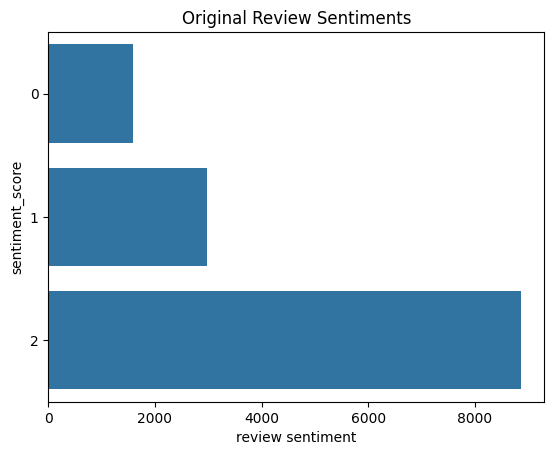

sentiment_score
2    8857
1    2969
0    1587
Name: count, dtype: int64

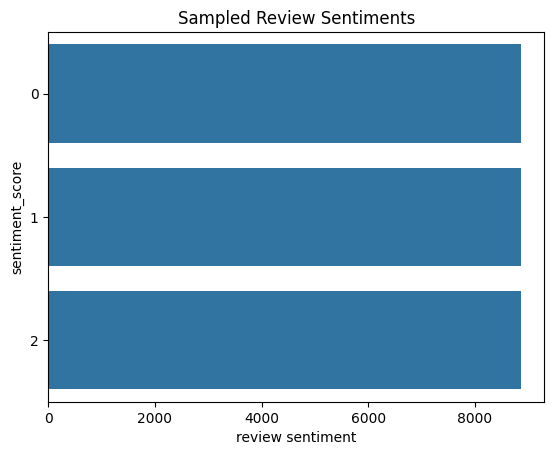

sentiment_score
0    8857
1    8857
2    8857
Name: count, dtype: int64

Original dataset size: 13413
Sampled dataset size: 26571


,site,user,review_target,review,score,max_score,norm_score,sentiment_score
0,MyAnimeList,Injenss,The Wind Rises,This film is very underwhelming. It loosely fo...,4,10,0.4,0
1,MyAnimeList,menmari,Sword Art Online,"First of all, I apologize for my poor writing ...",3,10,0.3,0
2,MyAnimeList,KKAJ,Black Butler,When I initially watched Black Butler my view ...,4,10,0.4,0
3,MyAnimeList,Luquillo,Hellsing Ultimate,Hellsing Ultimate is a title I remember lookin...,3,10,0.3,0
4,MyAnimeList,SCLFI,The Promised Neverland,"Neverland was a bit bizarre, it certainly felt...",3,10,0.3,0
...,...,...,...,...,...,...,...,...
26566,MyAnimeList,angelsreview,The Melancholy of Haruhi Suzumiya,((The same as second Season without endless 8)...,8,10,0.8,2
26567,MyAnimeList,LeaderTGW,Toradora!,[Spoilers Mates] I have had my Toradora box se...,8,10,0.8,2
26568,MyAnimeList,GigaSPX,Hyouka,"This is my first ever written review on MAL, a...",10,10,1.0,2
26569,MyAnimeList,Lord_Rutsah,Assassination Classroom,Quite literally my first reaction: Oh my god! ...,8,10,0.8,2


Loading masked dataset:
    Loading existing dataset file @ myanimelist_masked_data.dt...
Loading reviews dataset:
    Loading existing dataset file @ myanimelist_reviews_data.dt...
Masked pretraining:
    train_dataloader: (294 batches)
    test_dataloader: (84 batches)
    valid_dataloader: (42 batches)
Reviews training:
    train_dataloader: (582 batches)
    test_dataloader: (167 batches)
    valid_dataloader: (84 batches)
Training start for 'myanimelist' finetuning...


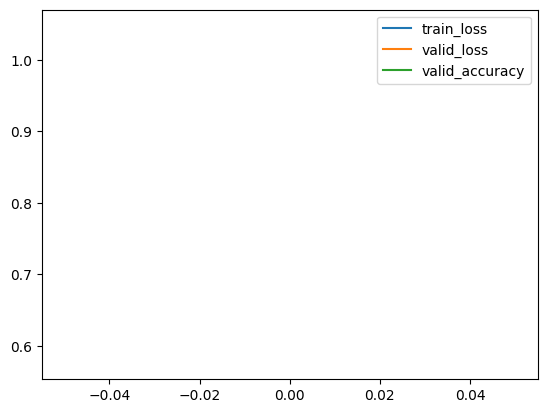

           : 100%|██████████| 84/84 [00:06<00:00, 12.60it/s, loss=0.851, num_correct=tensor(2, device='cuda:0')] 


Epoch: 1   :  51%|█████     | 297/582 [00:24<00:23, 12.27it/s, loss=0.915, num_correct=None]


KeyboardInterrupt: 

In [12]:
global_dataset_train_loop("myanimelist")

## Steam

Training BERT on Steam only.

Loaded training config:


{'tokenizer': BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
), 'pretrained_model_name': '', 'name': 'steam', 'class_names': ['negative', 'neutral', 'positive'], 'stop_delta':

Loaded steam:


,site,user,review_target,review,score,max_score
0,steam,Leif Davis,Schedule I,jesse we need to cook,1,1
1,steam,Lil_Hummus,Call of Duty®: Black Ops III,Still better than BO4,1,1
2,steam,ProAssassin303_1,Ready or Not,Very fun realistic game. Even when playing alo...,1,1
3,steam,haha shampoo,Forza Horizon 5,"For your next game, fix the AI so that the sit...",1,1
4,steam,Roughneck,DayZ,The last thing this game needed was a dlc. I p...,0,1
...,...,...,...,...,...,...
21360,steam,Valkia⭑☾,Call of Duty®,Not for this price.,0,1
21361,steam,Plops,Stellaris,This one time I helped develop a primitive wor...,1,1
21362,steam,Heretic,ELDEN RING,"Get a friend, install the ""Seamless Co-Op"" mod...",1,1
21363,steam,Darrin,Farming Simulator 25,It's honestly really good. If you're a fan of ...,1,1


C:\Users\Alan\AppData\Local\Temp\ipykernel_3808\3162132042.py:585: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = g.apply(lambda x: x.sample(max_group_size, replace=True)).reset_index(drop=True)


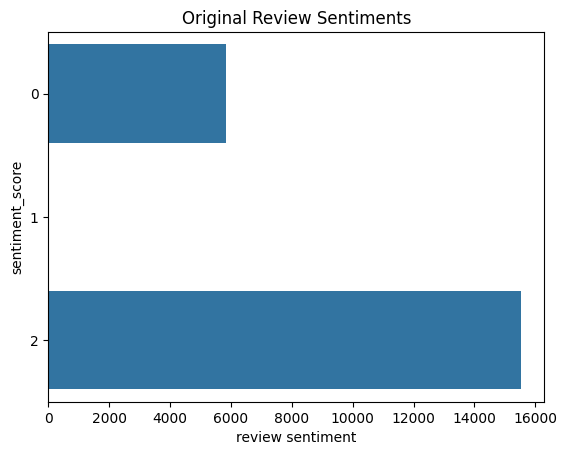

sentiment_score
2    15521
0     5844
Name: count, dtype: int64

In [ ]:
global_dataset_train_loop("steam")

## Metacritic

Training BERT on Metacritic only.

Loaded training config:


{'tokenizer': BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
), 'pretrained_model_name': '', 'name': 'metacritic', 'class_names': ['negative', 'neutral', 'positive'], 'stop_de

Loaded metacritic:


,site,user,review_target,review,score,max_score
0,metacritic,AaronAction,terraria,"Great game, couldn't wait for the Xbox and PS3...",10,10
1,metacritic,SomeSchoolKid,outer-wilds,"At the end of the day, I value the games that ...",10,10
2,metacritic,SKK-Sceptic,fortnite,If you ask me to rate this game it really depe...,7,10
3,metacritic,Jiminycampson5,balatro,"Sooo addicting, just a masterclass in keeping ...",10,10
4,metacritic,GreenPufferFish,payday-2,its a fun game i suppose but its a little repa...,6,10
...,...,...,...,...,...,...
8576,metacritic,Nandi,dota-2,"Dota had its pinnacle with Dota 2 Source 1, th...",3,10
8577,metacritic,Jhagman,tom-clancys-rainbow-six-siege,"This game is fantastic. It has great combat, m...",10,10
8578,metacritic,saskey,super-mario-odyssey,I had so much fun playing this game. Mario nev...,9,10
8579,metacritic,Teabos,hollow-knight,"Este juego me ha sorprendido en todo arte,OST ...",10,10


C:\Users\Alan\AppData\Local\Temp\ipykernel_3808\1641346163.py:585: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = g.apply(lambda x: x.sample(max_group_size, replace=True)).reset_index(drop=True)


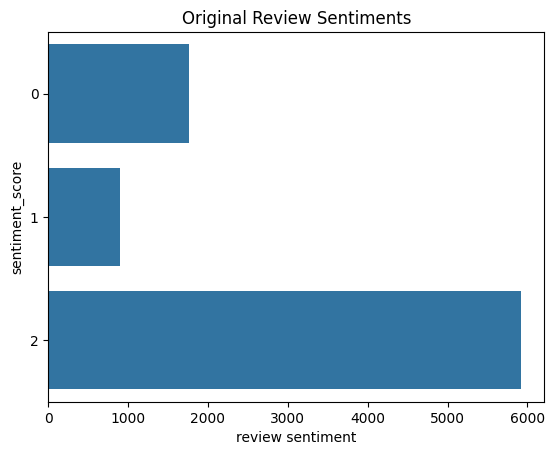

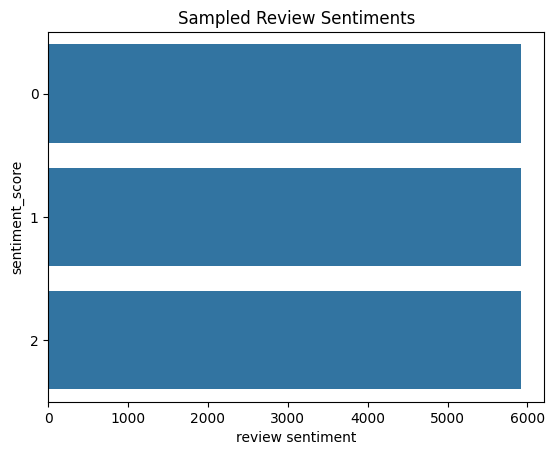

Original dataset size: 8581
Sampled dataset size: 17748


,site,user,review_target,review,score,max_score,norm_score,sentiment_score
0,metacritic,lkristina,brawl-stars,Literally on your team will only be noobs and ...,1,10,0.1,0
1,metacritic,Cirussly,hearthstone-heroes-of-warcraft,"Current meta is just based on no interactions,...",1,10,0.1,0
2,metacritic,Asparz,papers-please,the most boring game that has ever existed in ...,0,10,0.0,0
3,metacritic,Erdemtan,super-mario-maker-2,It’sgood but the physics is the main problem. ...,3,10,0.3,0
4,metacritic,YamiNoTsubasa,war-thunder,"Wort pay2win game ever, developpers do everyth...",0,10,0.0,0
...,...,...,...,...,...,...,...,...
17743,metacritic,dododederi,overwatch,"It's a game of love and hate, so much fun when...",8,10,0.8,2
17744,metacritic,anonymous1112,hollow-knight,"A master piece.\nChallenging game, beautiful m...",10,10,1.0,2
17745,metacritic,NianB_08,balatro,gioco spettacolare in tutto un rougue-like con...,9,10,0.9,2
17746,metacritic,m4kceT,minecraft,"Melhor jogo já feito ez, é literalmente o jogo...",10,10,1.0,2


Loading masked dataset:
    Loading existing dataset file @ metacritic_masked_data.dt...
    Error loading dataset file: [Errno 2] No such file or directory: 'c:\\Users\\Alan\\Desktop\\Open_Source\\BERT-TLSA-paper/data/metacritic_masked_data.dt'
    Creating new dataset file @ metacritic_masked_data.dt...
Loading reviews dataset:
    Loading existing dataset file @ metacritic_reviews_data.dt...
    Error loading dataset file: [Errno 2] No such file or directory: 'c:\\Users\\Alan\\Desktop\\Open_Source\\BERT-TLSA-paper/data/metacritic_reviews_data.dt'
    Creating new dataset file @ metacritic_reviews_data.dt...
Masked pretraining:
    train_dataloader: (188 batches)
    test_dataloader: (54 batches)
    valid_dataloader: (27 batches)
Reviews training:
    train_dataloader: (389 batches)
    test_dataloader: (111 batches)
    valid_dataloader: (56 batches)
Training start for 'metacritic' finetuning...


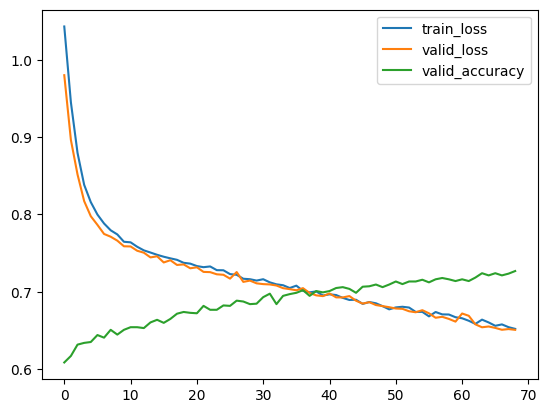

           : 100%|██████████| 56/56 [00:04<00:00, 12.95it/s, loss=1.02, num_correct=tensor(8, device='cuda:0')]  


           : 100%|██████████| 56/56 [00:04<00:00, 13.03it/s, loss=0.676, num_correct=tensor(13, device='cuda:0')]


           {'epoch': 1, 'train_loss': 0.9450458809158796, 'valid_loss': 0.8963331505656242, 'valid_accuracy': 0.6169014084507042}


           : 100%|██████████| 56/56 [00:04<00:00, 13.03it/s, loss=0.935, num_correct=tensor(10, device='cuda:0')]


           {'epoch': 2, 'train_loss': 0.8796173871942535, 'valid_loss': 0.8516621855752808, 'valid_accuracy': 0.6315492957746479}


           : 100%|██████████| 56/56 [00:04<00:00, 13.04it/s, loss=0.702, num_correct=tensor(11, device='cuda:0')]


           {'epoch': 3, 'train_loss': 0.8383240138963439, 'valid_loss': 0.8172380392040525, 'valid_accuracy': 0.6338028169014085}


           : 100%|██████████| 56/56 [00:04<00:00, 12.98it/s, loss=0.705, num_correct=tensor(10, device='cuda:0')]


           {'epoch': 4, 'train_loss': 0.8158918767784432, 'valid_loss': 0.7976583583014352, 'valid_accuracy': 0.6349295774647887}


           : 100%|██████████| 56/56 [00:04<00:00, 12.75it/s, loss=0.644, num_correct=tensor(12, device='cuda:0')]


           {'epoch': 5, 'train_loss': 0.7998553367384296, 'valid_loss': 0.786521070769855, 'valid_accuracy': 0.643943661971831}


           : 100%|██████████| 56/56 [00:04<00:00, 12.81it/s, loss=0.649, num_correct=tensor(13, device='cuda:0')]


           {'epoch': 6, 'train_loss': 0.788276171622975, 'valid_loss': 0.7747283311826842, 'valid_accuracy': 0.6405633802816901}


           : 100%|██████████| 56/56 [00:04<00:00, 13.05it/s, loss=0.673, num_correct=tensor(12, device='cuda:0')]


           {'epoch': 7, 'train_loss': 0.7794649282274025, 'valid_loss': 0.7711582024182592, 'valid_accuracy': 0.6507042253521127}


           : 100%|██████████| 56/56 [00:04<00:00, 13.06it/s, loss=0.791, num_correct=tensor(7, device='cuda:0')] 


           {'epoch': 8, 'train_loss': 0.7741204256570124, 'valid_loss': 0.7660664469003677, 'valid_accuracy': 0.6445070422535212}


           : 100%|██████████| 56/56 [00:04<00:00, 13.07it/s, loss=0.78, num_correct=tensor(10, device='cuda:0')] 


           {'epoch': 9, 'train_loss': 0.7646127416725943, 'valid_loss': 0.7587732523679733, 'valid_accuracy': 0.6507042253521127}


           : 100%|██████████| 56/56 [00:04<00:00, 13.01it/s, loss=0.903, num_correct=tensor(8, device='cuda:0')] 


           {'epoch': 10, 'train_loss': 0.7639109241012436, 'valid_loss': 0.7585728870970863, 'valid_accuracy': 0.6540845070422535}


           : 100%|██████████| 56/56 [00:04<00:00, 12.98it/s, loss=0.896, num_correct=tensor(10, device='cuda:0')]


           {'epoch': 11, 'train_loss': 0.758153238915539, 'valid_loss': 0.7530014647969178, 'valid_accuracy': 0.6540845070422535}


           : 100%|██████████| 56/56 [00:04<00:00, 13.03it/s, loss=1.02, num_correct=tensor(10, device='cuda:0')] 


           {'epoch': 12, 'train_loss': 0.7535040142603583, 'valid_loss': 0.7505009546875954, 'valid_accuracy': 0.6529577464788733}


           : 100%|██████████| 56/56 [00:04<00:00, 13.09it/s, loss=0.612, num_correct=tensor(10, device='cuda:0')]


           {'epoch': 13, 'train_loss': 0.7506883063169248, 'valid_loss': 0.7444044921014991, 'valid_accuracy': 0.660281690140845}


           : 100%|██████████| 56/56 [00:04<00:00, 12.91it/s, loss=1.01, num_correct=tensor(9, device='cuda:0')]  


           {'epoch': 14, 'train_loss': 0.7477616189684537, 'valid_loss': 0.7458335453910487, 'valid_accuracy': 0.663661971830986}


           : 100%|██████████| 56/56 [00:04<00:00, 12.70it/s, loss=0.495, num_correct=tensor(11, device='cuda:0')]


           {'epoch': 15, 'train_loss': 0.7452728196710424, 'valid_loss': 0.7378558473927634, 'valid_accuracy': 0.6597183098591549}


           : 100%|██████████| 56/56 [00:04<00:00, 12.99it/s, loss=0.9, num_correct=tensor(11, device='cuda:0')]  


           {'epoch': 16, 'train_loss': 0.743175019718381, 'valid_loss': 0.740767665207386, 'valid_accuracy': 0.6647887323943662}


           : 100%|██████████| 56/56 [00:04<00:00, 12.89it/s, loss=0.697, num_correct=tensor(9, device='cuda:0')] 


           {'epoch': 17, 'train_loss': 0.7412745532768857, 'valid_loss': 0.7346467040479183, 'valid_accuracy': 0.6715492957746478}


           : 100%|██████████| 56/56 [00:04<00:00, 12.88it/s, loss=0.958, num_correct=tensor(7, device='cuda:0')] 


           {'epoch': 18, 'train_loss': 0.7374071666544691, 'valid_loss': 0.7353318972246987, 'valid_accuracy': 0.6738028169014084}


           : 100%|██████████| 56/56 [00:04<00:00, 13.03it/s, loss=0.455, num_correct=tensor(13, device='cuda:0')]


           {'epoch': 19, 'train_loss': 0.7363412226993198, 'valid_loss': 0.730316907699619, 'valid_accuracy': 0.6726760563380282}


           : 100%|██████████| 56/56 [00:04<00:00, 12.98it/s, loss=1.02, num_correct=tensor(7, device='cuda:0')]  


           {'epoch': 20, 'train_loss': 0.7331936302712153, 'valid_loss': 0.7315938068287713, 'valid_accuracy': 0.6721126760563381}


           : 100%|██████████| 56/56 [00:04<00:00, 12.98it/s, loss=0.749, num_correct=tensor(10, device='cuda:0')]


           {'epoch': 21, 'train_loss': 0.7317460265901218, 'valid_loss': 0.7256411260792187, 'valid_accuracy': 0.6816901408450704}


           : 100%|██████████| 56/56 [00:04<00:00, 13.10it/s, loss=0.687, num_correct=tensor(10, device='cuda:0')]


           {'epoch': 22, 'train_loss': 0.732696153510812, 'valid_loss': 0.7253377128924642, 'valid_accuracy': 0.6766197183098591}


           : 100%|██████████| 56/56 [00:04<00:00, 13.06it/s, loss=0.696, num_correct=tensor(12, device='cuda:0')]


           {'epoch': 23, 'train_loss': 0.7279020817543363, 'valid_loss': 0.722531542714153, 'valid_accuracy': 0.6766197183098591}


           : 100%|██████████| 56/56 [00:04<00:00, 12.90it/s, loss=0.689, num_correct=tensor(11, device='cuda:0')]


           {'epoch': 24, 'train_loss': 0.7277526238736886, 'valid_loss': 0.7219238440905299, 'valid_accuracy': 0.6822535211267605}


           : 100%|██████████| 56/56 [00:04<00:00, 13.07it/s, loss=0.496, num_correct=tensor(13, device='cuda:0')]


           {'epoch': 25, 'train_loss': 0.7227717248057338, 'valid_loss': 0.7169447881834847, 'valid_accuracy': 0.6816901408450704}


           : 100%|██████████| 56/56 [00:04<00:00, 13.11it/s, loss=0.75, num_correct=tensor(10, device='cuda:0')] 


           {'epoch': 26, 'train_loss': 0.721880620273649, 'valid_loss': 0.7254596357899052, 'valid_accuracy': 0.6884507042253522}


           : 100%|██████████| 56/56 [00:04<00:00, 12.93it/s, loss=0.519, num_correct=tensor(13, device='cuda:0')]


           {'epoch': 27, 'train_loss': 0.7167801565100418, 'valid_loss': 0.7127259889883655, 'valid_accuracy': 0.6873239436619718}


           : 100%|██████████| 56/56 [00:04<00:00, 12.99it/s, loss=0.745, num_correct=tensor(7, device='cuda:0')] 


           {'epoch': 28, 'train_loss': 0.7161843016705354, 'valid_loss': 0.7143878362008503, 'valid_accuracy': 0.683943661971831}


           : 100%|██████████| 56/56 [00:04<00:00, 13.05it/s, loss=0.537, num_correct=tensor(13, device='cuda:0')]


           {'epoch': 29, 'train_loss': 0.7144249761932, 'valid_loss': 0.7108496321099145, 'valid_accuracy': 0.6845070422535211}


           : 100%|██████████| 56/56 [00:04<00:00, 12.85it/s, loss=0.785, num_correct=tensor(9, device='cuda:0')] 


           {'epoch': 30, 'train_loss': 0.7161637809711741, 'valid_loss': 0.709830742329359, 'valid_accuracy': 0.6929577464788732}


           : 100%|██████████| 56/56 [00:04<00:00, 13.12it/s, loss=0.664, num_correct=tensor(10, device='cuda:0')]


           {'epoch': 31, 'train_loss': 0.7121134311497058, 'valid_loss': 0.7094173649592059, 'valid_accuracy': 0.6974647887323944}


           : 100%|██████████| 56/56 [00:04<00:00, 13.16it/s, loss=0.646, num_correct=tensor(10, device='cuda:0')]


           {'epoch': 32, 'train_loss': 0.709562467731976, 'valid_loss': 0.7080282260264669, 'valid_accuracy': 0.683943661971831}


           : 100%|██████████| 56/56 [00:04<00:00, 13.05it/s, loss=0.56, num_correct=tensor(10, device='cuda:0')] 


           {'epoch': 33, 'train_loss': 0.7083951479211871, 'valid_loss': 0.7045882450682777, 'valid_accuracy': 0.6946478873239437}


           : 100%|██████████| 56/56 [00:04<00:00, 13.00it/s, loss=0.602, num_correct=tensor(12, device='cuda:0')]


           {'epoch': 34, 'train_loss': 0.7047962690380362, 'valid_loss': 0.7033291608095169, 'valid_accuracy': 0.6969014084507043}


           : 100%|██████████| 56/56 [00:04<00:00, 13.05it/s, loss=0.62, num_correct=tensor(11, device='cuda:0')] 


           {'epoch': 35, 'train_loss': 0.707831006123658, 'valid_loss': 0.701888200959989, 'valid_accuracy': 0.6985915492957746}


           : 100%|██████████| 56/56 [00:04<00:00, 12.50it/s, loss=0.913, num_correct=tensor(6, device='cuda:0')] 


           {'epoch': 36, 'train_loss': 0.7011486969141237, 'valid_loss': 0.7045943875397954, 'valid_accuracy': 0.7019718309859155}


           : 100%|██████████| 56/56 [00:04<00:00, 13.06it/s, loss=0.676, num_correct=tensor(12, device='cuda:0')]


           {'epoch': 37, 'train_loss': 0.6991521817246562, 'valid_loss': 0.6983506844512054, 'valid_accuracy': 0.6946478873239437}


           : 100%|██████████| 56/56 [00:04<00:00, 12.86it/s, loss=0.496, num_correct=tensor(13, device='cuda:0')]


           {'epoch': 38, 'train_loss': 0.7004353430093407, 'valid_loss': 0.6952917272491115, 'valid_accuracy': 0.7008450704225352}


           : 100%|██████████| 56/56 [00:04<00:00, 12.98it/s, loss=0.464, num_correct=tensor(13, device='cuda:0')]


           {'epoch': 39, 'train_loss': 0.6950986859577787, 'valid_loss': 0.6943173009370055, 'valid_accuracy': 0.6991549295774648}


           : 100%|██████████| 56/56 [00:04<00:00, 13.15it/s, loss=0.942, num_correct=tensor(9, device='cuda:0')] 


           {'epoch': 40, 'train_loss': 0.6966197283837973, 'valid_loss': 0.6977213557277407, 'valid_accuracy': 0.7008450704225352}


           : 100%|██████████| 56/56 [00:04<00:00, 13.09it/s, loss=0.548, num_correct=tensor(11, device='cuda:0')]


           {'epoch': 41, 'train_loss': 0.6957004660965544, 'valid_loss': 0.6926876758890492, 'valid_accuracy': 0.7047887323943662}


           : 100%|██████████| 56/56 [00:04<00:00, 13.08it/s, loss=0.81, num_correct=tensor(10, device='cuda:0')] 


           {'epoch': 42, 'train_loss': 0.6920382904516088, 'valid_loss': 0.6925886385142803, 'valid_accuracy': 0.7059154929577465}


           : 100%|██████████| 56/56 [00:04<00:00, 13.09it/s, loss=0.848, num_correct=tensor(8, device='cuda:0')] 


           {'epoch': 43, 'train_loss': 0.6893303149923261, 'valid_loss': 0.6943679297608989, 'valid_accuracy': 0.7036619718309859}


           : 100%|██████████| 56/56 [00:04<00:00, 13.01it/s, loss=0.621, num_correct=tensor(10, device='cuda:0')]


           {'epoch': 44, 'train_loss': 0.6896062268083077, 'valid_loss': 0.6883471815713814, 'valid_accuracy': 0.6985915492957746}


           : 100%|██████████| 56/56 [00:04<00:00, 13.03it/s, loss=0.611, num_correct=tensor(10, device='cuda:0')]


           {'epoch': 45, 'train_loss': 0.6842514523963389, 'valid_loss': 0.6846422361476081, 'valid_accuracy': 0.7064788732394366}


           : 100%|██████████| 56/56 [00:04<00:00, 12.89it/s, loss=1.08, num_correct=tensor(7, device='cuda:0')]  


           {'epoch': 46, 'train_loss': 0.6866709540926093, 'valid_loss': 0.6864728448646409, 'valid_accuracy': 0.7070422535211267}


           : 100%|██████████| 56/56 [00:04<00:00, 12.95it/s, loss=0.711, num_correct=tensor(10, device='cuda:0')]


           {'epoch': 47, 'train_loss': 0.6850384404083144, 'valid_loss': 0.6827489568718842, 'valid_accuracy': 0.7092957746478873}


           : 100%|██████████| 56/56 [00:04<00:00, 13.08it/s, loss=0.594, num_correct=tensor(11, device='cuda:0')]


           {'epoch': 48, 'train_loss': 0.6813309325963488, 'valid_loss': 0.6813881450465747, 'valid_accuracy': 0.7059154929577465}


           : 100%|██████████| 56/56 [00:04<00:00, 12.32it/s, loss=0.601, num_correct=tensor(11, device='cuda:0')]


           {'epoch': 49, 'train_loss': 0.6771747703570633, 'valid_loss': 0.6799597905150482, 'valid_accuracy': 0.7092957746478873}


           : 100%|██████████| 56/56 [00:04<00:00, 12.38it/s, loss=0.912, num_correct=tensor(9, device='cuda:0')] 


           {'epoch': 50, 'train_loss': 0.6796831306271197, 'valid_loss': 0.6782687572496278, 'valid_accuracy': 0.7132394366197183}


           : 100%|██████████| 56/56 [00:04<00:00, 12.98it/s, loss=0.716, num_correct=tensor(9, device='cuda:0')] 


           {'epoch': 51, 'train_loss': 0.6805353610558498, 'valid_loss': 0.6778630832476276, 'valid_accuracy': 0.7098591549295775}


           : 100%|██████████| 56/56 [00:04<00:00, 12.60it/s, loss=0.628, num_correct=tensor(11, device='cuda:0')]


           {'epoch': 52, 'train_loss': 0.6795286921578385, 'valid_loss': 0.6747076527348587, 'valid_accuracy': 0.7132394366197183}


           : 100%|██████████| 56/56 [00:04<00:00, 12.91it/s, loss=0.707, num_correct=tensor(10, device='cuda:0')]


           {'epoch': 53, 'train_loss': 0.6738430867618032, 'valid_loss': 0.6734182903809207, 'valid_accuracy': 0.7132394366197183}


           : 100%|██████████| 56/56 [00:04<00:00, 12.85it/s, loss=1.22, num_correct=tensor(5, device='cuda:0')]  


           {'epoch': 54, 'train_loss': 0.6739381137268096, 'valid_loss': 0.6760930631841932, 'valid_accuracy': 0.7154929577464789}


           : 100%|██████████| 56/56 [00:04<00:00, 12.96it/s, loss=1.02, num_correct=tensor(10, device='cuda:0')] 


           {'epoch': 55, 'train_loss': 0.6680847093807701, 'valid_loss': 0.6720594284789903, 'valid_accuracy': 0.712112676056338}


           : 100%|██████████| 56/56 [00:04<00:00, 12.93it/s, loss=0.557, num_correct=tensor(13, device='cuda:0')]


           {'epoch': 56, 'train_loss': 0.6737748343871002, 'valid_loss': 0.6663209881101336, 'valid_accuracy': 0.716056338028169}


           : 100%|██████████| 56/56 [00:04<00:00, 12.72it/s, loss=0.832, num_correct=tensor(11, device='cuda:0')]


           {'epoch': 57, 'train_loss': 0.6706670884301545, 'valid_loss': 0.6675302194697517, 'valid_accuracy': 0.7177464788732394}


           : 100%|██████████| 56/56 [00:04<00:00, 12.90it/s, loss=0.33, num_correct=tensor(14, device='cuda:0')] 


           {'epoch': 58, 'train_loss': 0.6705169420315857, 'valid_loss': 0.6648297043783324, 'valid_accuracy': 0.716056338028169}


           : 100%|██████████| 56/56 [00:04<00:00, 12.81it/s, loss=0.385, num_correct=tensor(13, device='cuda:0')]


           {'epoch': 59, 'train_loss': 0.6670099273132482, 'valid_loss': 0.6613103145999568, 'valid_accuracy': 0.7138028169014085}


           : 100%|██████████| 56/56 [00:04<00:00, 12.93it/s, loss=1.41, num_correct=tensor(9, device='cuda:0')]  


           {'epoch': 60, 'train_loss': 0.6656463754514189, 'valid_loss': 0.6718148477375507, 'valid_accuracy': 0.716056338028169}


           : 100%|██████████| 56/56 [00:04<00:00, 12.98it/s, loss=0.997, num_correct=tensor(6, device='cuda:0')] 


           {'epoch': 61, 'train_loss': 0.6624285515905346, 'valid_loss': 0.6688566947621959, 'valid_accuracy': 0.7138028169014085}


           : 100%|██████████| 56/56 [00:04<00:00, 12.98it/s, loss=0.659, num_correct=tensor(10, device='cuda:0')]


           {'epoch': 62, 'train_loss': 0.6583756346322577, 'valid_loss': 0.657792615039008, 'valid_accuracy': 0.7183098591549296}


           : 100%|██████████| 56/56 [00:04<00:00, 12.87it/s, loss=0.444, num_correct=tensor(12, device='cuda:0')]


           {'epoch': 63, 'train_loss': 0.6638788190169935, 'valid_loss': 0.6539978682994843, 'valid_accuracy': 0.723943661971831}


           : 100%|██████████| 56/56 [00:04<00:00, 12.93it/s, loss=0.776, num_correct=tensor(8, device='cuda:0')] 


           {'epoch': 64, 'train_loss': 0.6602502846012998, 'valid_loss': 0.6549998335540295, 'valid_accuracy': 0.7211267605633803}


           : 100%|██████████| 56/56 [00:04<00:00, 12.64it/s, loss=0.552, num_correct=tensor(12, device='cuda:0')]


           {'epoch': 65, 'train_loss': 0.6559040942504657, 'valid_loss': 0.6531751379370689, 'valid_accuracy': 0.723943661971831}


           : 100%|██████████| 56/56 [00:04<00:00, 12.46it/s, loss=0.406, num_correct=tensor(12, device='cuda:0')]


           {'epoch': 66, 'train_loss': 0.6577199297576454, 'valid_loss': 0.650765593030623, 'valid_accuracy': 0.7211267605633803}


           : 100%|██████████| 56/56 [00:04<00:00, 13.02it/s, loss=0.672, num_correct=tensor(9, device='cuda:0')] 


           {'epoch': 67, 'train_loss': 0.6541428955171286, 'valid_loss': 0.6516660074038165, 'valid_accuracy': 0.7233802816901408}


           : 100%|██████████| 56/56 [00:04<00:00, 12.98it/s, loss=0.81, num_correct=tensor(9, device='cuda:0')]  


           {'epoch': 68, 'train_loss': 0.6519297287825754, 'valid_loss': 0.6506701872817108, 'valid_accuracy': 0.7267605633802817}
Stopping early...

Finetuning test...


           : 100%|██████████| 111/111 [00:08<00:00, 12.50it/s, loss=0.744, num_correct=tensor(20, device='cuda:0')]


              precision    recall  f1-score   support

    negative       0.71      0.75      0.73      1174
     neutral       0.68      0.69      0.69      1228
    positive       0.77      0.71      0.74      1148

    accuracy                           0.72      3550
   macro avg       0.72      0.72      0.72      3550
weighted avg       0.72      0.72      0.72      3550



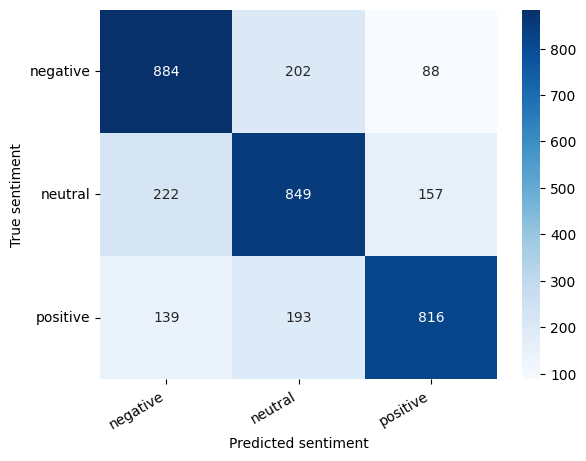

In [ ]:
global_dataset_train_loop("metacritic")

## Rotten Tomatoes

Training BERT on Rotten Tomatoes only.

Loaded training config:


{'tokenizer': BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
), 'pretrained_model_name': '', 'name': 'rotten_tomatoes', 'class_names': ['negative', 'neutral', 'positive'], 'st

Loaded rotten_tomatoes:


,site,user,review_target,review,score,max_score
0,Rotten Tomatoes,Lee N,Prestige,"I love entertaining movies that draw me in, an...",5.0,5
1,Rotten Tomatoes,Markus L,Inception,My mind is but a construct of my own imagination,5.0,5
2,Rotten Tomatoes,XRP V,Full Metal Jacket,I have seen this movie countless times it’s on...,5.0,5
3,Rotten Tomatoes,Horror fan 4,1066050-Party Girl,Nice cast but this movie was boring. Wasn't fu...,0.5,5
4,Rotten Tomatoes,Vitor Felipe A,Iron Man,"filme incrivel,mostra muito bem a origem do ho...",4.5,5
...,...,...,...,...,...,...
4177,Rotten Tomatoes,,Interstellar 2014,Um dos melhores filmes de todos os tempos.,5.0,5
4178,Rotten Tomatoes,,A Minecraft Movie,"If you grew up playing minecraft, or played it...",5.0,5
4179,Rotten Tomatoes,Andrew L,1065684-Braveheart,Masterpiece. Stirringly shot and beautifully a...,5.0,5
4180,Rotten Tomatoes,thiago s,World-War-Z,"Filme mais ou menos, o roteiro é mais ou menos...",1.0,5


C:\Users\Alan\AppData\Local\Temp\ipykernel_3808\1641346163.py:585: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = g.apply(lambda x: x.sample(max_group_size, replace=True)).reset_index(drop=True)


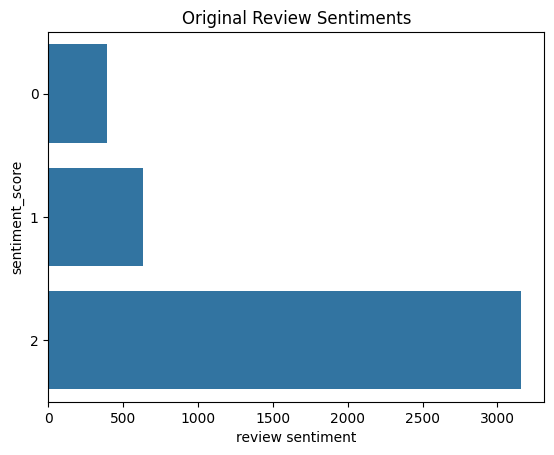

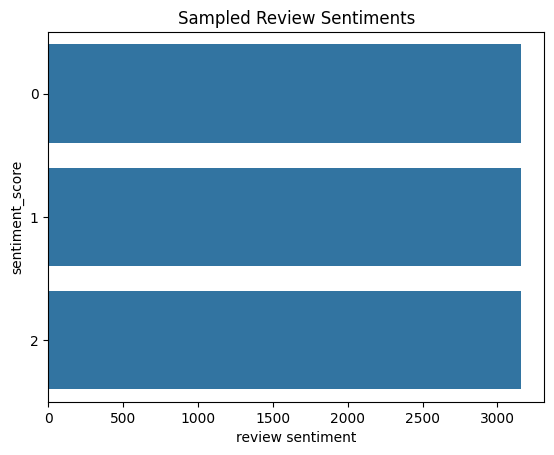

Original dataset size: 4182
Sampled dataset size: 9465


,site,user,review_target,review,score,max_score,norm_score,sentiment_score
0,Rotten Tomatoes,Finn O,Star Wars Episode Vii The Force Awakens,"Nice interpretation of A New Hope, but still l...",0.5,5,0.1,0
1,Rotten Tomatoes,Jermaine S,Monsters Inc,I hate this movie SOoooOO much🤮😡 I hate it,0.5,5,0.1,0
2,Rotten Tomatoes,,Shadow In The Cloud,Started out nice and spooky with the premise b...,1.5,5,0.3,0
3,Rotten Tomatoes,,Bagman 2024,"Um conceito interessante, mundialmente conheci...",0.5,5,0.1,0
4,Rotten Tomatoes,,Quel Maledetto Treno Blindato,Despite the fact that the whole plot is made u...,2.0,5,0.4,0
...,...,...,...,...,...,...,...,...
9460,Rotten Tomatoes,Brad M,Your Name 2017,Makoto Shinkai’s Your Name (Kimi no Na wa) is ...,5.0,5,1.0,2
9461,Rotten Tomatoes,George P,Spider Man Into The Spider Verse,better than the sequel! \nvery underrated!,4.5,5,0.9,2
9462,Rotten Tomatoes,Kenji C,Green Mile,As atuaçoes são fodas para caralho alem do fin...,5.0,5,1.0,2
9463,Rotten Tomatoes,Korra N,Prestige,An underappreciated classic from auteur Christ...,4.5,5,0.9,2


Loading masked dataset:
    Loading existing dataset file @ rotten_tomatoes_masked_data.dt...
    Error loading dataset file: [Errno 2] No such file or directory: 'c:\\Users\\Alan\\Desktop\\Open_Source\\BERT-TLSA-paper/data/rotten_tomatoes_masked_data.dt'
    Creating new dataset file @ rotten_tomatoes_masked_data.dt...
Loading reviews dataset:
    Loading existing dataset file @ rotten_tomatoes_reviews_data.dt...
    Error loading dataset file: [Errno 2] No such file or directory: 'c:\\Users\\Alan\\Desktop\\Open_Source\\BERT-TLSA-paper/data/rotten_tomatoes_reviews_data.dt'
    Creating new dataset file @ rotten_tomatoes_reviews_data.dt...
Masked pretraining:
    train_dataloader: (92 batches)
    test_dataloader: (27 batches)
    valid_dataloader: (14 batches)
Reviews training:
    train_dataloader: (208 batches)
    test_dataloader: (60 batches)
    valid_dataloader: (30 batches)
Training start for 'rotten_tomatoes' finetuning...


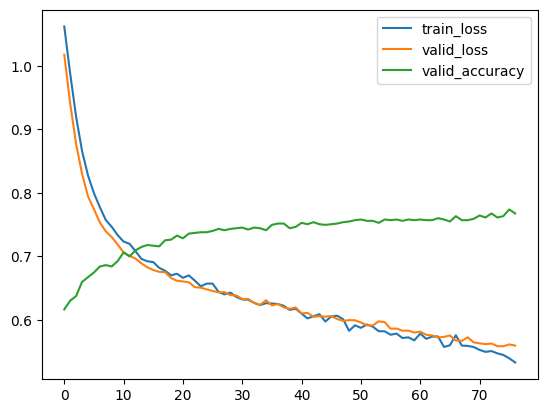

           : 100%|██████████| 30/30 [00:02<00:00, 12.95it/s, loss=1.05, num_correct=tensor(10, device='cuda:0')] 


           : 100%|██████████| 30/30 [00:02<00:00, 13.09it/s, loss=0.911, num_correct=tensor(11, device='cuda:0')]


           {'epoch': 1, 'train_loss': 0.9875784304279548, 'valid_loss': 0.9405871788660686, 'valid_accuracy': 0.6304118268215417}


           : 100%|██████████| 30/30 [00:02<00:00, 12.97it/s, loss=0.919, num_correct=tensor(12, device='cuda:0')]


           {'epoch': 2, 'train_loss': 0.9196018860317193, 'valid_loss': 0.8767761786778768, 'valid_accuracy': 0.6378035902851109}


           : 100%|██████████| 30/30 [00:02<00:00, 12.89it/s, loss=0.906, num_correct=tensor(12, device='cuda:0')]


           {'epoch': 3, 'train_loss': 0.8660832207936507, 'valid_loss': 0.8300301134586334, 'valid_accuracy': 0.6599788806758183}


           : 100%|██████████| 30/30 [00:02<00:00, 13.08it/s, loss=0.732, num_correct=tensor(12, device='cuda:0')]


           {'epoch': 4, 'train_loss': 0.8274412255447644, 'valid_loss': 0.7946835199991862, 'valid_accuracy': 0.6673706441393875}


           : 100%|██████████| 30/30 [00:02<00:00, 13.06it/s, loss=0.711, num_correct=tensor(13, device='cuda:0')]


           {'epoch': 5, 'train_loss': 0.7996424307616857, 'valid_loss': 0.7744430561860403, 'valid_accuracy': 0.6747624076029567}


           : 100%|██████████| 30/30 [00:02<00:00, 13.04it/s, loss=0.671, num_correct=tensor(14, device='cuda:0')]


           {'epoch': 6, 'train_loss': 0.7775752343810521, 'valid_loss': 0.7535466472307841, 'valid_accuracy': 0.6842661034846885}


           : 100%|██████████| 30/30 [00:02<00:00, 12.75it/s, loss=0.783, num_correct=tensor(10, device='cuda:0')]


           {'epoch': 7, 'train_loss': 0.7573173097693003, 'valid_loss': 0.7394681831200918, 'valid_accuracy': 0.6863780359028511}


           : 100%|██████████| 30/30 [00:02<00:00, 12.69it/s, loss=0.784, num_correct=tensor(13, device='cuda:0')]


           {'epoch': 8, 'train_loss': 0.7465964532815493, 'valid_loss': 0.7305593132972718, 'valid_accuracy': 0.6842661034846885}


           : 100%|██████████| 30/30 [00:02<00:00, 13.07it/s, loss=0.668, num_correct=tensor(15, device='cuda:0')]


           {'epoch': 9, 'train_loss': 0.7335595663708563, 'valid_loss': 0.7188037772973378, 'valid_accuracy': 0.6927138331573389}


           : 100%|██████████| 30/30 [00:02<00:00, 12.80it/s, loss=0.627, num_correct=tensor(12, device='cuda:0')]


           {'epoch': 10, 'train_loss': 0.7234702111723331, 'valid_loss': 0.706258891026179, 'valid_accuracy': 0.706441393875396}


           : 100%|██████████| 30/30 [00:02<00:00, 13.08it/s, loss=0.703, num_correct=tensor(14, device='cuda:0')]


           {'epoch': 11, 'train_loss': 0.7198963328622855, 'valid_loss': 0.7010152200857799, 'valid_accuracy': 0.7001055966209081}


           : 100%|██████████| 30/30 [00:02<00:00, 12.69it/s, loss=0.76, num_correct=tensor(13, device='cuda:0')] 


           {'epoch': 12, 'train_loss': 0.708436854613515, 'valid_loss': 0.6967374314864476, 'valid_accuracy': 0.7096092925026399}


           : 100%|██████████| 30/30 [00:02<00:00, 12.21it/s, loss=0.755, num_correct=tensor(15, device='cuda:0')]


           {'epoch': 13, 'train_loss': 0.696185217024042, 'valid_loss': 0.689034969607989, 'valid_accuracy': 0.7148891235480465}


           : 100%|██████████| 30/30 [00:02<00:00, 12.77it/s, loss=0.746, num_correct=tensor(14, device='cuda:0')]


           {'epoch': 14, 'train_loss': 0.6923890035026349, 'valid_loss': 0.6830339332421621, 'valid_accuracy': 0.7180570221752904}


           : 100%|██████████| 30/30 [00:02<00:00, 12.97it/s, loss=0.612, num_correct=tensor(16, device='cuda:0')]


           {'epoch': 15, 'train_loss': 0.6911930989187497, 'valid_loss': 0.6786146779855092, 'valid_accuracy': 0.7170010559662091}


           : 100%|██████████| 30/30 [00:02<00:00, 13.07it/s, loss=0.812, num_correct=tensor(12, device='cuda:0')]


           {'epoch': 16, 'train_loss': 0.6821320892239993, 'valid_loss': 0.6758612384398778, 'valid_accuracy': 0.7159450897571278}


           : 100%|██████████| 30/30 [00:02<00:00, 12.75it/s, loss=0.687, num_correct=tensor(14, device='cuda:0')]


           {'epoch': 17, 'train_loss': 0.6774940191266628, 'valid_loss': 0.6751832137505214, 'valid_accuracy': 0.7254487856388595}


           : 100%|██████████| 30/30 [00:02<00:00, 13.08it/s, loss=0.742, num_correct=tensor(12, device='cuda:0')]


           {'epoch': 18, 'train_loss': 0.6703095271323736, 'valid_loss': 0.6661373714605967, 'valid_accuracy': 0.7265047518479408}


           : 100%|██████████| 30/30 [00:02<00:00, 13.10it/s, loss=0.602, num_correct=tensor(14, device='cuda:0')]


           {'epoch': 19, 'train_loss': 0.6727917989572654, 'valid_loss': 0.6616466253995895, 'valid_accuracy': 0.7328405491024287}


           : 100%|██████████| 30/30 [00:02<00:00, 11.90it/s, loss=0.598, num_correct=tensor(16, device='cuda:0')]


           {'epoch': 20, 'train_loss': 0.6664286139779366, 'valid_loss': 0.6607065190871556, 'valid_accuracy': 0.7286166842661035}


           : 100%|██████████| 30/30 [00:02<00:00, 12.60it/s, loss=0.733, num_correct=tensor(12, device='cuda:0')]


           {'epoch': 21, 'train_loss': 0.6701903244337211, 'valid_loss': 0.6593639403581619, 'valid_accuracy': 0.7360084477296727}


           : 100%|██████████| 30/30 [00:02<00:00, 12.96it/s, loss=0.453, num_correct=tensor(16, device='cuda:0')]


           {'epoch': 22, 'train_loss': 0.6620217577482645, 'valid_loss': 0.651663691798846, 'valid_accuracy': 0.737064413938754}


           : 100%|██████████| 30/30 [00:02<00:00, 13.06it/s, loss=0.704, num_correct=tensor(14, device='cuda:0')]


           {'epoch': 23, 'train_loss': 0.6530467438189169, 'valid_loss': 0.6508560289939245, 'valid_accuracy': 0.7381203801478353}


           : 100%|██████████| 30/30 [00:02<00:00, 12.98it/s, loss=0.72, num_correct=tensor(13, device='cuda:0')] 


           {'epoch': 24, 'train_loss': 0.6572544687929062, 'valid_loss': 0.6483065028985341, 'valid_accuracy': 0.7381203801478353}


           : 100%|██████████| 30/30 [00:02<00:00, 13.11it/s, loss=0.711, num_correct=tensor(13, device='cuda:0')]


           {'epoch': 25, 'train_loss': 0.6572930712539417, 'valid_loss': 0.6457261949777603, 'valid_accuracy': 0.7402323125659979}


           : 100%|██████████| 30/30 [00:02<00:00, 13.07it/s, loss=0.758, num_correct=tensor(14, device='cuda:0')]


           {'epoch': 26, 'train_loss': 0.6443929552243879, 'valid_loss': 0.6435304294029872, 'valid_accuracy': 0.7434002111932418}


           : 100%|██████████| 30/30 [00:02<00:00, 13.03it/s, loss=0.805, num_correct=tensor(13, device='cuda:0')]


           {'epoch': 27, 'train_loss': 0.6402825257525995, 'valid_loss': 0.6437751372655233, 'valid_accuracy': 0.7412882787750792}


           : 100%|██████████| 30/30 [00:02<00:00, 12.98it/s, loss=0.711, num_correct=tensor(14, device='cuda:0')]


           {'epoch': 28, 'train_loss': 0.6431318502873182, 'valid_loss': 0.6390874981880188, 'valid_accuracy': 0.7434002111932418}


           : 100%|██████████| 30/30 [00:02<00:00, 12.60it/s, loss=0.75, num_correct=tensor(11, device='cuda:0')] 


           {'epoch': 29, 'train_loss': 0.6363358662392085, 'valid_loss': 0.6386567244927088, 'valid_accuracy': 0.7444561774023232}


           : 100%|██████████| 30/30 [00:02<00:00, 12.94it/s, loss=0.477, num_correct=tensor(16, device='cuda:0')]


           {'epoch': 30, 'train_loss': 0.6323328253168327, 'valid_loss': 0.6330229808886846, 'valid_accuracy': 0.7455121436114044}


           : 100%|██████████| 30/30 [00:02<00:00, 12.92it/s, loss=0.704, num_correct=tensor(14, device='cuda:0')]


           {'epoch': 31, 'train_loss': 0.6319874496414111, 'valid_loss': 0.633113631606102, 'valid_accuracy': 0.7423442449841605}


           : 100%|██████████| 30/30 [00:02<00:00, 12.93it/s, loss=0.52, num_correct=tensor(15, device='cuda:0')] 


           {'epoch': 32, 'train_loss': 0.6268986375071108, 'valid_loss': 0.6271258374055226, 'valid_accuracy': 0.7455121436114044}


           : 100%|██████████| 30/30 [00:02<00:00, 13.13it/s, loss=0.433, num_correct=tensor(16, device='cuda:0')]


           {'epoch': 33, 'train_loss': 0.6234280393960384, 'valid_loss': 0.6236298541227977, 'valid_accuracy': 0.7444561774023232}


           : 100%|██████████| 30/30 [00:02<00:00, 13.07it/s, loss=0.856, num_correct=tensor(12, device='cuda:0')]


           {'epoch': 34, 'train_loss': 0.6264664383175281, 'valid_loss': 0.6310726910829544, 'valid_accuracy': 0.7412882787750792}


           : 100%|██████████| 30/30 [00:02<00:00, 13.00it/s, loss=0.661, num_correct=tensor(14, device='cuda:0')]


           {'epoch': 35, 'train_loss': 0.6259208158231698, 'valid_loss': 0.622976690530777, 'valid_accuracy': 0.7497360084477297}


           : 100%|██████████| 30/30 [00:02<00:00, 12.97it/s, loss=0.987, num_correct=tensor(10, device='cuda:0')]


           {'epoch': 36, 'train_loss': 0.6252607979740088, 'valid_loss': 0.6251075605551402, 'valid_accuracy': 0.7518479408658922}


           : 100%|██████████| 30/30 [00:02<00:00, 13.02it/s, loss=0.786, num_correct=tensor(12, device='cuda:0')]


           {'epoch': 37, 'train_loss': 0.622379634099511, 'valid_loss': 0.6199983050425847, 'valid_accuracy': 0.7518479408658922}


           : 100%|██████████| 30/30 [00:02<00:00, 13.12it/s, loss=0.346, num_correct=tensor(16, device='cuda:0')]


           {'epoch': 38, 'train_loss': 0.6158476679657514, 'valid_loss': 0.6175776571035385, 'valid_accuracy': 0.7444561774023232}


           : 100%|██████████| 30/30 [00:02<00:00, 13.05it/s, loss=0.503, num_correct=tensor(16, device='cuda:0')]


           {'epoch': 39, 'train_loss': 0.6178649974843631, 'valid_loss': 0.6197014093399048, 'valid_accuracy': 0.7465681098204857}


           : 100%|██████████| 30/30 [00:02<00:00, 12.95it/s, loss=0.516, num_correct=tensor(15, device='cuda:0')]


           {'epoch': 40, 'train_loss': 0.610016976411526, 'valid_loss': 0.6104704727729161, 'valid_accuracy': 0.7529039070749736}


           : 100%|██████████| 30/30 [00:02<00:00, 13.01it/s, loss=0.678, num_correct=tensor(11, device='cuda:0')]


           {'epoch': 41, 'train_loss': 0.6025102498153081, 'valid_loss': 0.6111535121997197, 'valid_accuracy': 0.750791974656811}


           : 100%|██████████| 30/30 [00:02<00:00, 12.75it/s, loss=0.41, num_correct=tensor(17, device='cuda:0')] 


           {'epoch': 42, 'train_loss': 0.6058503208825221, 'valid_loss': 0.6050830622514088, 'valid_accuracy': 0.7539598732840549}


           : 100%|██████████| 30/30 [00:02<00:00, 13.05it/s, loss=0.46, num_correct=tensor(16, device='cuda:0')] 


           {'epoch': 43, 'train_loss': 0.6091218046449984, 'valid_loss': 0.6058977156877517, 'valid_accuracy': 0.750791974656811}


           : 100%|██████████| 30/30 [00:02<00:00, 12.67it/s, loss=0.557, num_correct=tensor(14, device='cuda:0')]


           {'epoch': 44, 'train_loss': 0.5976034008109798, 'valid_loss': 0.6054008493820826, 'valid_accuracy': 0.7497360084477297}


           : 100%|██████████| 30/30 [00:02<00:00, 13.09it/s, loss=0.573, num_correct=tensor(14, device='cuda:0')]


           {'epoch': 45, 'train_loss': 0.6055677611953937, 'valid_loss': 0.6061147550741831, 'valid_accuracy': 0.750791974656811}


           : 100%|██████████| 30/30 [00:02<00:00, 13.00it/s, loss=0.507, num_correct=tensor(14, device='cuda:0')]


           {'epoch': 46, 'train_loss': 0.6067266404055632, 'valid_loss': 0.6015749603509903, 'valid_accuracy': 0.7518479408658922}


           : 100%|██████████| 30/30 [00:02<00:00, 12.70it/s, loss=0.489, num_correct=tensor(16, device='cuda:0')]


           {'epoch': 47, 'train_loss': 0.6012827831392105, 'valid_loss': 0.5985871543486913, 'valid_accuracy': 0.7539598732840549}


           : 100%|██████████| 30/30 [00:02<00:00, 13.01it/s, loss=0.49, num_correct=tensor(14, device='cuda:0')] 


           {'epoch': 48, 'train_loss': 0.582959330157162, 'valid_loss': 0.5997577518224716, 'valid_accuracy': 0.7550158394931362}


           : 100%|██████████| 30/30 [00:02<00:00, 13.00it/s, loss=0.874, num_correct=tensor(11, device='cuda:0')]


           {'epoch': 49, 'train_loss': 0.5916480651268592, 'valid_loss': 0.5995757639408111, 'valid_accuracy': 0.7571277719112989}


           : 100%|██████████| 30/30 [00:02<00:00, 13.03it/s, loss=0.544, num_correct=tensor(14, device='cuda:0')]


           {'epoch': 50, 'train_loss': 0.5876354339460914, 'valid_loss': 0.5959890941778819, 'valid_accuracy': 0.7581837381203802}


           : 100%|██████████| 30/30 [00:02<00:00, 13.10it/s, loss=0.29, num_correct=tensor(16, device='cuda:0')] 


           {'epoch': 51, 'train_loss': 0.5928814929838364, 'valid_loss': 0.5916919271151225, 'valid_accuracy': 0.7560718057022175}


           : 100%|██████████| 30/30 [00:02<00:00, 12.95it/s, loss=0.666, num_correct=tensor(14, device='cuda:0')]


           {'epoch': 52, 'train_loss': 0.5895229322979083, 'valid_loss': 0.5915398408969244, 'valid_accuracy': 0.7560718057022175}


           : 100%|██████████| 30/30 [00:02<00:00, 13.09it/s, loss=0.81, num_correct=tensor(14, device='cuda:0')] 


           {'epoch': 53, 'train_loss': 0.5823579106766444, 'valid_loss': 0.5978581547737122, 'valid_accuracy': 0.7529039070749736}


           : 100%|██████████| 30/30 [00:02<00:00, 12.94it/s, loss=0.771, num_correct=tensor(13, device='cuda:0')]


           {'epoch': 54, 'train_loss': 0.582294664488962, 'valid_loss': 0.5967264652252198, 'valid_accuracy': 0.7581837381203802}


           : 100%|██████████| 30/30 [00:02<00:00, 13.05it/s, loss=0.514, num_correct=tensor(18, device='cuda:0')]


           {'epoch': 55, 'train_loss': 0.5767909974003067, 'valid_loss': 0.5862527281045914, 'valid_accuracy': 0.7571277719112989}


           : 100%|██████████| 30/30 [00:02<00:00, 12.66it/s, loss=0.691, num_correct=tensor(14, device='cuda:0')]


           {'epoch': 56, 'train_loss': 0.5786213934994661, 'valid_loss': 0.5865782231092453, 'valid_accuracy': 0.7581837381203802}


           : 100%|██████████| 30/30 [00:02<00:00, 13.04it/s, loss=0.442, num_correct=tensor(16, device='cuda:0')]


           {'epoch': 57, 'train_loss': 0.571615447361882, 'valid_loss': 0.5830560694138209, 'valid_accuracy': 0.7560718057022175}


           : 100%|██████████| 30/30 [00:02<00:00, 12.96it/s, loss=0.692, num_correct=tensor(13, device='cuda:0')]


           {'epoch': 58, 'train_loss': 0.5727181429974735, 'valid_loss': 0.5832952817281087, 'valid_accuracy': 0.7581837381203802}


           : 100%|██████████| 30/30 [00:02<00:00, 12.92it/s, loss=0.613, num_correct=tensor(14, device='cuda:0')]


           {'epoch': 59, 'train_loss': 0.5679835515240064, 'valid_loss': 0.5802025357882182, 'valid_accuracy': 0.7571277719112989}


           : 100%|██████████| 30/30 [00:02<00:00, 12.94it/s, loss=0.567, num_correct=tensor(14, device='cuda:0')]


           {'epoch': 60, 'train_loss': 0.578578042726104, 'valid_loss': 0.5817377656698227, 'valid_accuracy': 0.7581837381203802}


           : 100%|██████████| 30/30 [00:02<00:00, 12.65it/s, loss=0.58, num_correct=tensor(14, device='cuda:0')] 


           {'epoch': 61, 'train_loss': 0.5704195154114411, 'valid_loss': 0.576758818825086, 'valid_accuracy': 0.7571277719112989}


           : 100%|██████████| 30/30 [00:02<00:00, 13.07it/s, loss=0.469, num_correct=tensor(15, device='cuda:0')]


           {'epoch': 62, 'train_loss': 0.5738334575524697, 'valid_loss': 0.575698588291804, 'valid_accuracy': 0.7571277719112989}


           : 100%|██████████| 30/30 [00:02<00:00, 12.94it/s, loss=0.539, num_correct=tensor(15, device='cuda:0')]


           {'epoch': 63, 'train_loss': 0.574100979245626, 'valid_loss': 0.5726002911726634, 'valid_accuracy': 0.7602956705385427}


           : 100%|██████████| 30/30 [00:02<00:00, 12.94it/s, loss=0.538, num_correct=tensor(16, device='cuda:0')]


           {'epoch': 64, 'train_loss': 0.5575892755475181, 'valid_loss': 0.5734055280685425, 'valid_accuracy': 0.7581837381203802}


           : 100%|██████████| 30/30 [00:02<00:00, 12.92it/s, loss=0.59, num_correct=tensor(12, device='cuda:0')] 


           {'epoch': 65, 'train_loss': 0.5602460583815208, 'valid_loss': 0.5756284862756729, 'valid_accuracy': 0.7550158394931362}


           : 100%|██████████| 30/30 [00:02<00:00, 13.02it/s, loss=0.439, num_correct=tensor(15, device='cuda:0')]


           {'epoch': 66, 'train_loss': 0.5760303520812438, 'valid_loss': 0.567677566409111, 'valid_accuracy': 0.7634635691657867}


           : 100%|██████████| 30/30 [00:02<00:00, 13.09it/s, loss=0.47, num_correct=tensor(15, device='cuda:0')] 


           {'epoch': 67, 'train_loss': 0.5597534861702186, 'valid_loss': 0.5670990775028865, 'valid_accuracy': 0.7571277719112989}


           : 100%|██████████| 30/30 [00:02<00:00, 12.98it/s, loss=0.894, num_correct=tensor(14, device='cuda:0')]


           {'epoch': 68, 'train_loss': 0.5591942243851148, 'valid_loss': 0.5728273431460063, 'valid_accuracy': 0.7571277719112989}


           : 100%|██████████| 30/30 [00:02<00:00, 12.97it/s, loss=0.435, num_correct=tensor(16, device='cuda:0')]


           {'epoch': 69, 'train_loss': 0.5575275968473691, 'valid_loss': 0.5648411323626836, 'valid_accuracy': 0.7592397043294614}


           : 100%|██████████| 30/30 [00:02<00:00, 13.02it/s, loss=0.668, num_correct=tensor(14, device='cuda:0')]


           {'epoch': 70, 'train_loss': 0.552913665628204, 'valid_loss': 0.5633438736200332, 'valid_accuracy': 0.764519535374868}


           : 100%|██████████| 30/30 [00:02<00:00, 12.62it/s, loss=0.719, num_correct=tensor(13, device='cuda:0')]


           {'epoch': 71, 'train_loss': 0.5498477653242074, 'valid_loss': 0.5620437562465668, 'valid_accuracy': 0.7613516367476241}


           : 100%|██████████| 30/30 [00:02<00:00, 12.73it/s, loss=0.822, num_correct=tensor(13, device='cuda:0')]


           {'epoch': 72, 'train_loss': 0.5511097054068859, 'valid_loss': 0.5628921310106914, 'valid_accuracy': 0.7676874340021119}


           : 100%|██████████| 30/30 [00:02<00:00, 12.58it/s, loss=0.643, num_correct=tensor(13, device='cuda:0')]


           {'epoch': 73, 'train_loss': 0.5474741928852521, 'valid_loss': 0.5588199317455291, 'valid_accuracy': 0.7613516367476241}


           : 100%|██████████| 30/30 [00:02<00:00, 12.64it/s, loss=0.569, num_correct=tensor(16, device='cuda:0')]


           {'epoch': 74, 'train_loss': 0.544968916891286, 'valid_loss': 0.5586237033208211, 'valid_accuracy': 0.7634635691657867}


           : 100%|██████████| 30/30 [00:02<00:00, 12.77it/s, loss=0.564, num_correct=tensor(15, device='cuda:0')]


           {'epoch': 75, 'train_loss': 0.53974349431407, 'valid_loss': 0.5615358730157216, 'valid_accuracy': 0.7740232312565998}


           : 100%|██████████| 30/30 [00:02<00:00, 13.16it/s, loss=0.522, num_correct=tensor(14, device='cuda:0')]


           {'epoch': 76, 'train_loss': 0.5331363179362737, 'valid_loss': 0.5597048064072927, 'valid_accuracy': 0.7676874340021119}
Stopping early...

Finetuning test...


           : 100%|██████████| 60/60 [00:04<00:00, 12.58it/s, loss=0.435, num_correct=tensor(4, device='cuda:0')] 


              precision    recall  f1-score   support

    negative       0.82      0.85      0.84       614
     neutral       0.68      0.70      0.69       654
    positive       0.77      0.71      0.74       625

    accuracy                           0.75      1893
   macro avg       0.76      0.76      0.75      1893
weighted avg       0.75      0.75      0.75      1893



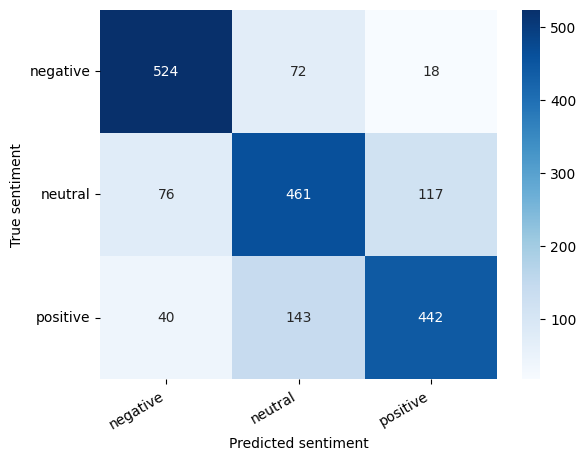

In [9]:
global_dataset_train_loop("rotten_tomatoes")

## Combined (MyAnimeList, Steam, Metacritic, Rotten Tomatoes)

Training BERT on all 4 platforms.

Loaded training config:


{'tokenizer': BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
), 'pretrained_model_name': '', 'name': 'myanimelist-steam-metacritic-rotten_tomatoes', 'class_names': ['negative'

Loaded myanimelist-steam-metacritic-rotten_tomatoes:


,site,user,review_target,review,score,max_score
0,steam,splunty,PGA TOUR 2K25,"The game itself is fun, but there are annoying...",0.0,1
1,Rotten Tomatoes,M B,Avengers Infinity War,Best super hero movie ever made IMO. Better th...,5.0,5
2,metacritic,viniciusjunur,super-mario-odyssey,[SPOILER ALERT: This review contains spoilers.],10.0,10
3,steam,Koovster,Fallout 76,"No, they have not fixed the game.",0.0,1
4,metacritic,Kemet_,elden-ring,It’s simple: Dark Souls 1 + Dark Souls 2 + Dar...,9.0,10
...,...,...,...,...,...,...
47536,MyAnimeList,DeadlySilvers,Texhnolyze,The story is a complex look at the harsh natur...,10.0,10
47537,steam,JooberDoober,Last Epoch,EDIT: I originally wrote this back in 0.7-0.8....,1.0,1
47538,steam,stanrep,Jurassic World Evolution 2,"If you love dinosaurs, park builders and the J...",1.0,1
47539,steam,DaveBlack,Forza Horizon 5,this is a great game.. when it works. after 20...,0.0,1


C:\Users\Alan\AppData\Local\Temp\ipykernel_3808\1641346163.py:585: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = g.apply(lambda x: x.sample(max_group_size, replace=True)).reset_index(drop=True)


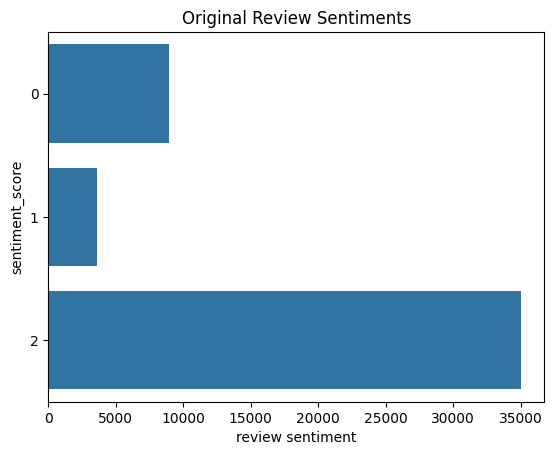

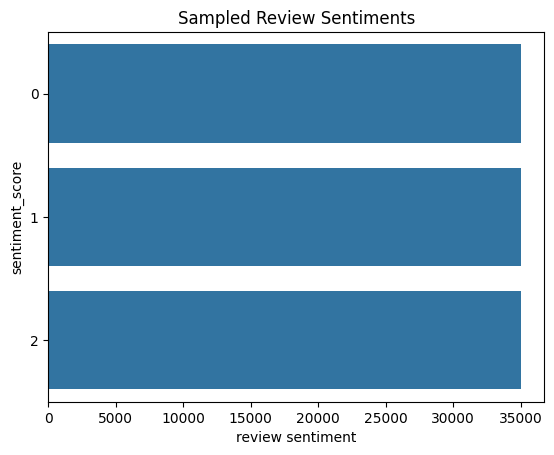

Original dataset size: 47541
Sampled dataset size: 105027


,site,user,review_target,review,score,max_score,norm_score,sentiment_score
0,steam,Bardeux,Last Epoch,"Good gameplay tropes, but very doubtful that t...",0.0,1,0.0,0
1,steam,NE,War Thunder,I genuinely once believed in Gaijin to be a re...,0.0,1,0.0,0
2,MyAnimeList,nowa_,One Punch Man,One Punch Man is a comedy/parody shounen anime...,3.0,10,0.3,0
3,steam,SirLink,Monster Hunter Wilds,As someone who has put over 5000 hours into th...,0.0,1,0.0,0
4,steam,Xander,Total War: WARHAMMER III,Would I recommend getting Total War: Warhammer...,0.0,1,0.0,0
...,...,...,...,...,...,...,...,...
105022,steam,Count Olaf,War Thunder,"""free""",1.0,1,1.0,2
105023,MyAnimeList,bleachsai,Texhnolyze,Since many of the members have elucidated real...,9.0,10,0.9,2
105024,MyAnimeList,Ethan_07,Whisper of the Heart,""" Country road, take me home ... "" A classic J...",9.0,10,0.9,2
105025,MyAnimeList,Master10K,Ergo Proxy,"Ergo Proxy is basically another puzzling, post...",8.0,10,0.8,2


Loading masked dataset:
    Loading existing dataset file @ myanimelist-steam-metacritic-rotten_tomatoes_masked_data.dt...
    Error loading dataset file: [Errno 2] No such file or directory: 'c:\\Users\\Alan\\Desktop\\Open_Source\\BERT-TLSA-paper/data/myanimelist-steam-metacritic-rotten_tomatoes_masked_data.dt'
    Creating new dataset file @ myanimelist-steam-metacritic-rotten_tomatoes_masked_data.dt...
Loading reviews dataset:
    Loading existing dataset file @ myanimelist-steam-metacritic-rotten_tomatoes_reviews_data.dt...
    Error loading dataset file: [Errno 2] No such file or directory: 'c:\\Users\\Alan\\Desktop\\Open_Source\\BERT-TLSA-paper/data/myanimelist-steam-metacritic-rotten_tomatoes_reviews_data.dt'
    Creating new dataset file @ myanimelist-steam-metacritic-rotten_tomatoes_reviews_data.dt...
Masked pretraining:
    train_dataloader: (1040 batches)
    test_dataloader: (298 batches)
    valid_dataloader: (149 batches)
Reviews training:
    train_dataloader: (2298 batc

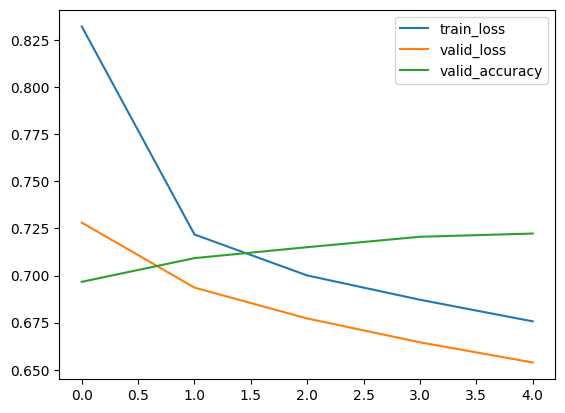

           : 100%|██████████| 329/329 [00:26<00:00, 12.65it/s, loss=0.732, num_correct=tensor(4, device='cuda:0')] 


           : 100%|██████████| 329/329 [00:25<00:00, 12.96it/s, loss=0.635, num_correct=tensor(5, device='cuda:0')] 


           {'epoch': 1, 'train_loss': 0.7217653447306602, 'valid_loss': 0.6935897589092197, 'valid_accuracy': 0.7092259354470152}


           : 100%|██████████| 329/329 [00:25<00:00, 12.87it/s, loss=0.542, num_correct=tensor(6, device='cuda:0')] 


           {'epoch': 2, 'train_loss': 0.7000237706435878, 'valid_loss': 0.677208487114283, 'valid_accuracy': 0.7150337998667048}


           : 100%|██████████| 329/329 [00:25<00:00, 12.92it/s, loss=0.802, num_correct=tensor(5, device='cuda:0')] 


           {'epoch': 3, 'train_loss': 0.6871434333430257, 'valid_loss': 0.6645604584898267, 'valid_accuracy': 0.7205560316100161}


           : 100%|██████████| 329/329 [00:26<00:00, 12.45it/s, loss=0.738, num_correct=tensor(5, device='cuda:0')] 


           {'epoch': 4, 'train_loss': 0.6756792441853448, 'valid_loss': 0.6538537283255337, 'valid_accuracy': 0.7222698276682853}


Epoch: 5   :  17%|█▋        | 385/2298 [00:32<02:40, 11.95it/s, loss=0.815, num_correct=None]


KeyboardInterrupt: 

In [10]:
global_dataset_train_loop(["myanimelist", "steam", "metacritic", "rotten_tomatoes"])